In [361]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import joblib

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
# from lazypredict.Supervised import LazyRegressor

plt.rcParams['savefig.dpi'] = 144

%matplotlib inline

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [362]:
# pip install lazypredict

## **1. Làm sạch dữ liệu**

## **2. Trực quan hoá**

In [363]:
df = pd.read_csv("/content/drive/MyDrive/web_crawler/data/clean_car.csv")
df.head()

,Price,CarBrand,CarModel,MfgDate,Mileage,Condition,GearBox,Fuel,CarOrigin,CarType,CarSeats,WarrantyPolicy
0,9.400000e+08,Vinfast,VF8,2023.0,0.0,Mới,Tự động,Điện,Việt Nam,SUV,5.0,Bảo hành hãng
1,9.990000e+08,Hyundai,Santa Fe,2021.0,20000.0,Đã sử dụng,Tự động,Xăng,Việt Nam,SUV,7.0,Bảo hành hãng
2,1.058000e+09,Hyundai,Santa Fe,2021.0,24000.0,Đã sử dụng,Tự động,Dầu,NaN,SUV,7.0,Bảo hành hãng
3,4.600000e+08,Mazda,3,2018.0,44658.0,Đã sử dụng,Tự động,Xăng,Việt Nam,Sedan,5.0,Bảo hành hãng
4,4.150000e+08,Lexus,GS,2007.0,135000.0,Đã sử dụng,Tự động,Xăng,Mỹ,Sedan,4.0,Bảo hành hãng


In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12869 entries, 0 to 12868
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           12866 non-null  float64
 1   CarBrand        12817 non-null  object 
 2   CarModel        12868 non-null  object 
 3   MfgDate         12851 non-null  float64
 4   Mileage         12734 non-null  float64
 5   Condition       12869 non-null  object 
 6   GearBox         12814 non-null  object 
 7   Fuel            12869 non-null  object 
 8   CarOrigin       10258 non-null  object 
 9   CarType         11898 non-null  object 
 10  CarSeats        12506 non-null  float64
 11  WarrantyPolicy  12869 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.2+ MB


In [365]:
# df["CarBrand"].value_counts()

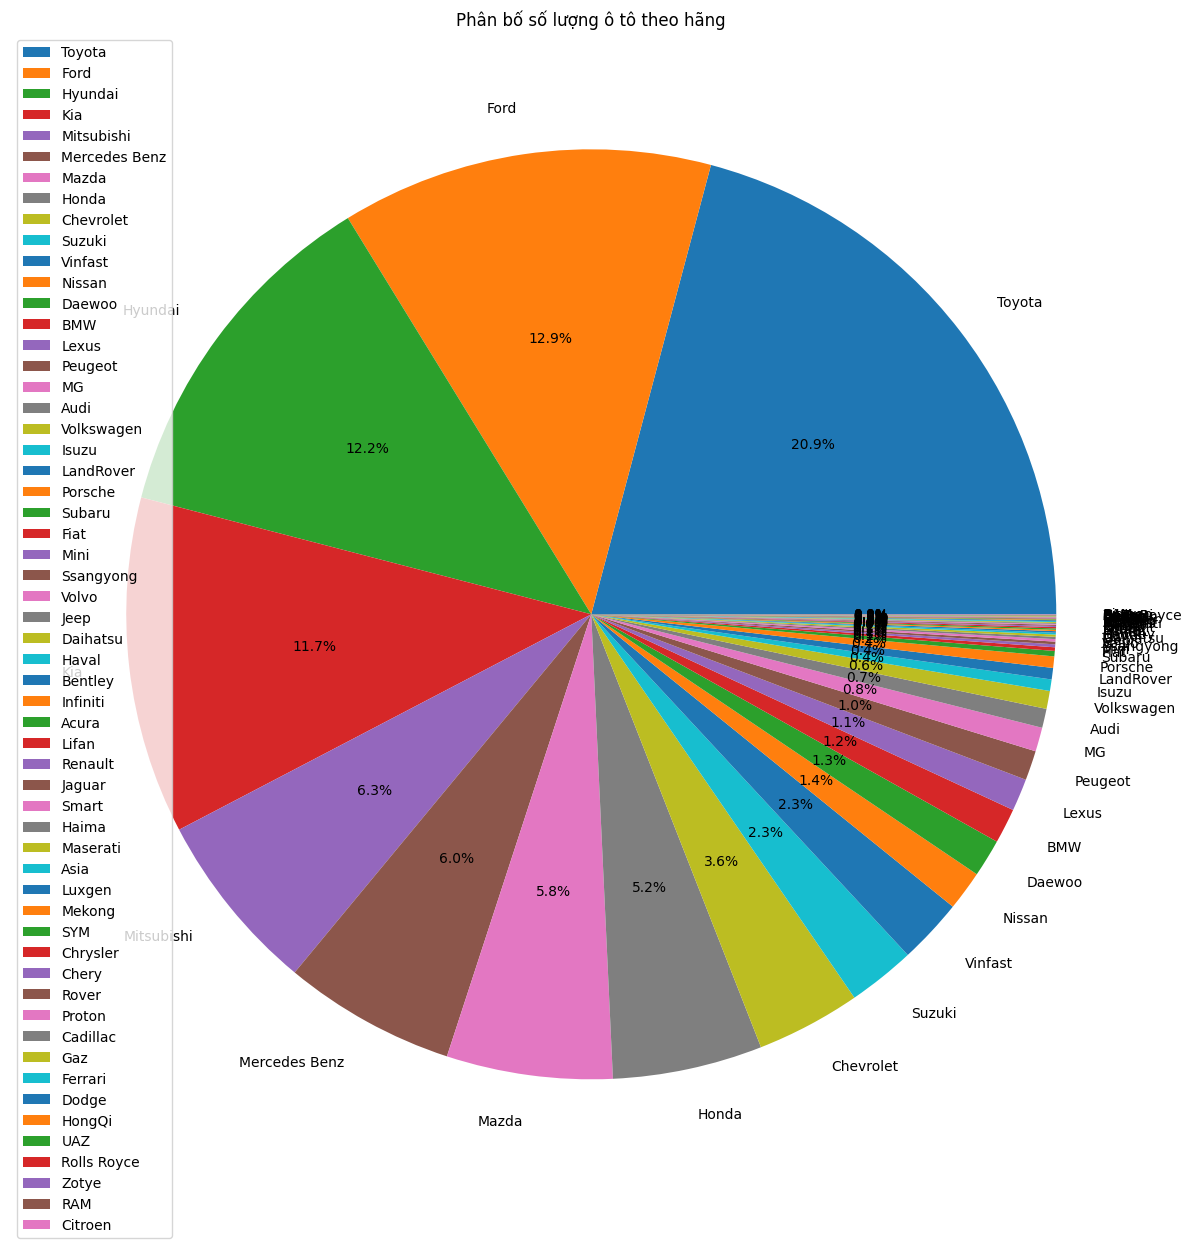

In [366]:
plt.figure(figsize=(15,20))
brands = df["CarBrand"].value_counts().sort_values(ascending=False)
plt.pie(brands.values, labels=brands.keys(), autopct='%1.1f%%')
plt.title("Phân bố số lượng ô tô theo hãng")
plt.legend(labels=brands.keys())
plt.show()

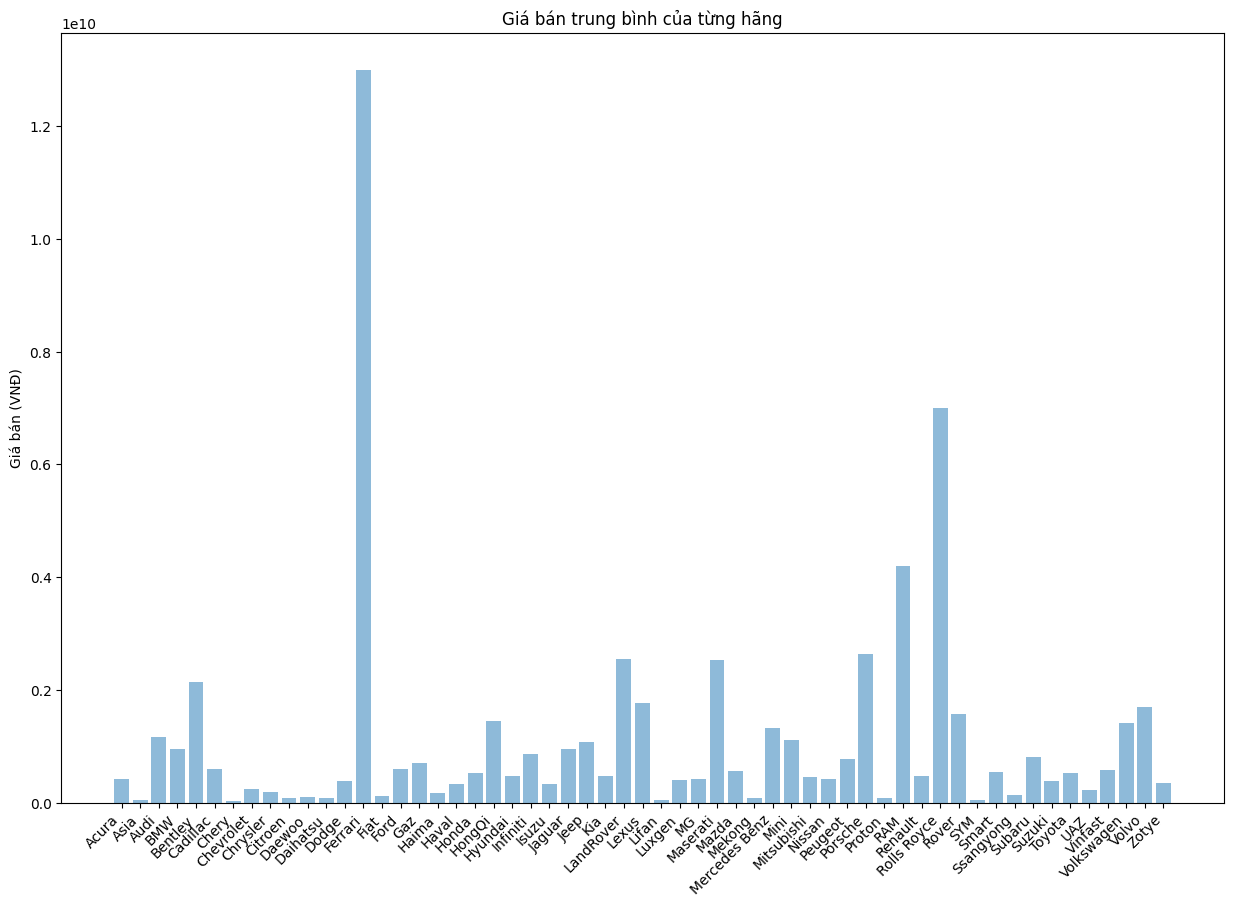

In [367]:
price_brand = df.groupby("CarBrand").mean()["Price"]
price_brand.index
plt.figure(figsize=(15,10))
plt.bar(price_brand.index, price_brand, align='center', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Giá bán (VNĐ)')
plt.title('Giá bán trung bình của từng hãng')
plt.show()

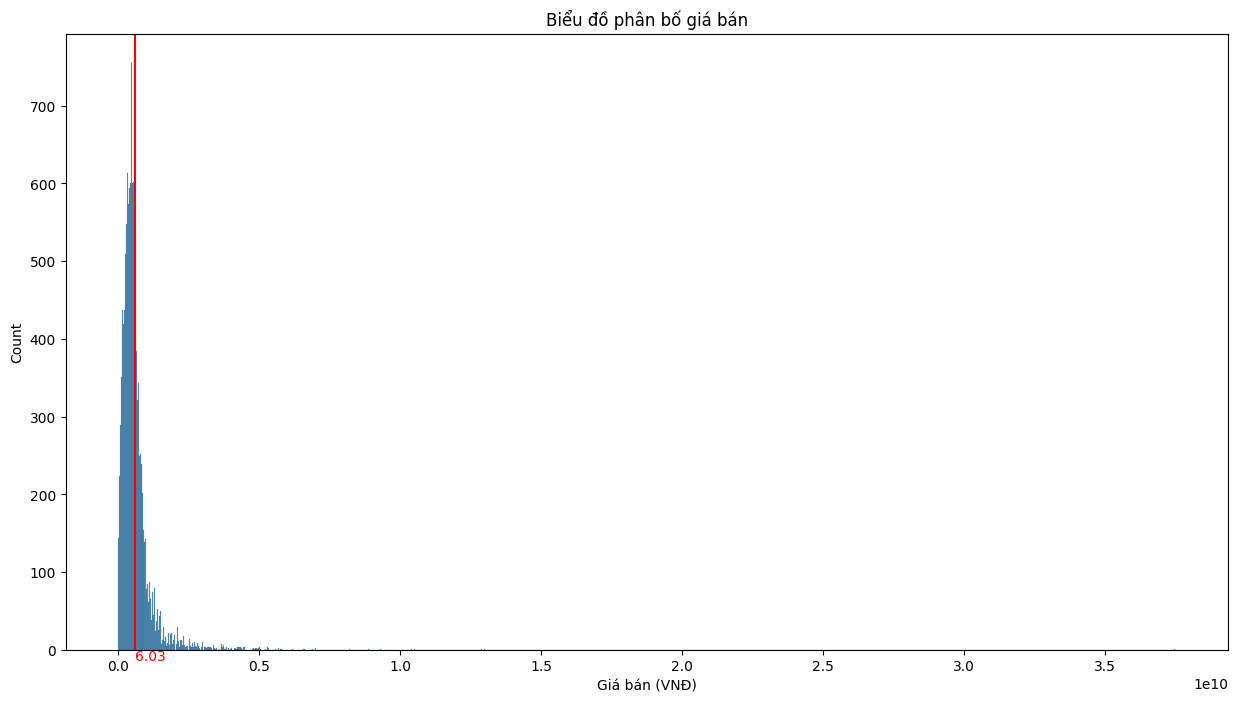

In [368]:
price_sale = df["Price"].dropna()
price_mean = price_sale.mean()
plt.figure(figsize=(15,8))
sns.histplot(data=price_sale)
plt.axvline(price_mean, color='r')
plt.xlabel('Giá bán (VNĐ)')
plt.title("Biểu đồ phân bố giá bán")
_price_mean = price_mean / 1e8
plt.text(price_mean, 0, f'{_price_mean:.2f}', color='r', verticalalignment='top', horizontalalignment='left')
plt.show()


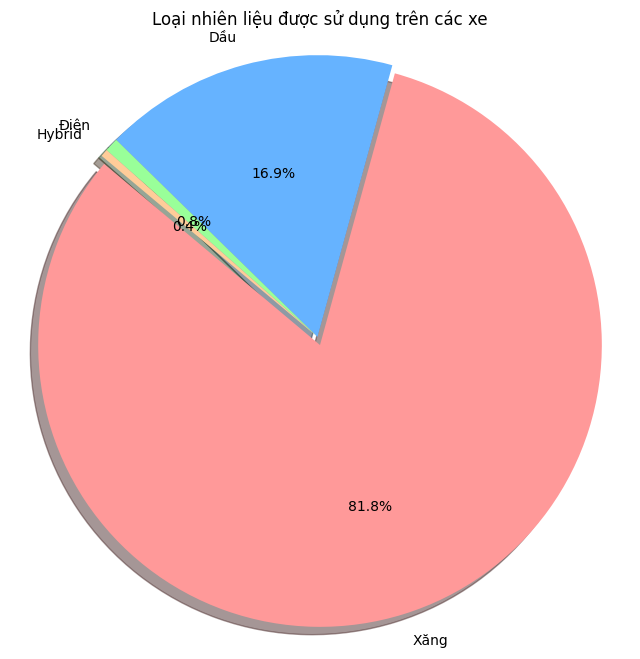

In [369]:
# Tính số lượng xe cho từng loại nhiên liệu
fuel_counts = df["Fuel"].value_counts()

# Lấy tên loại nhiên liệu và số lượng tương ứng
fuel_labels = fuel_counts.index
fuel_sizes = fuel_counts.values

# Màu sắc và tách phần
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
explode = (0.03, 0, 0, 0)  # Tách một phần (10%) của biểu đồ

# Vẽ biểu đồ hình tròn
plt.figure(figsize=(8, 8))
plt.pie(fuel_sizes, explode=explode, labels=fuel_labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Đảm bảo biểu đồ hình tròn có hình dạng tự nhiên
plt.title('Loại nhiên liệu được sử dụng trên các xe')

# Hiển thị biểu đồ
plt.show()

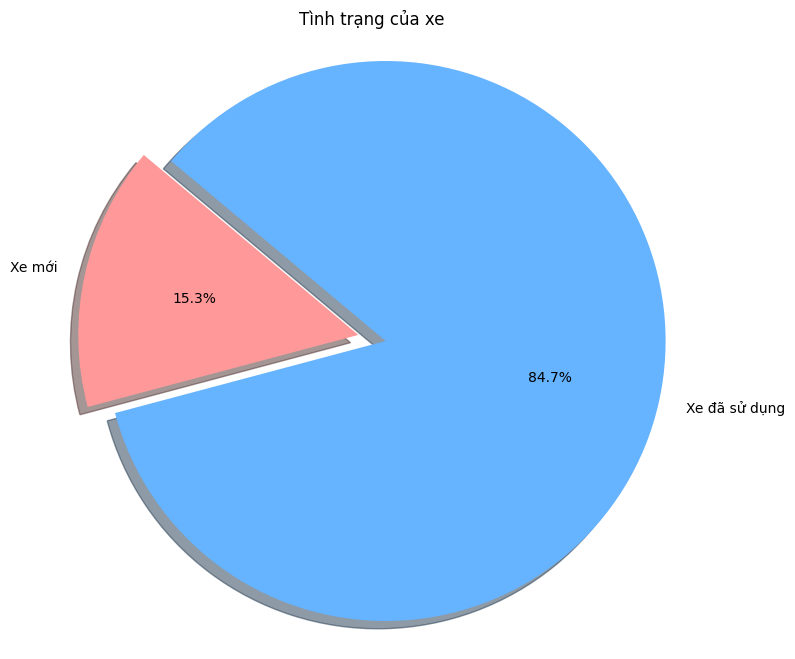

In [370]:
# Tính số lượng xe mới và đã sử dụng
new_cars = len(df[df['Condition'] == 'Mới'])
used_cars = len(df[df['Condition'] == 'Đã sử dụng'])

# Tạo dữ liệu cho biểu đồ hình tròn
labels = ['Xe mới', 'Xe đã sử dụng']
sizes = [new_cars, used_cars]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # Tách một phần (10%) của biểu đồ

# Vẽ biểu đồ hình tròn
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Đảm bảo biểu đồ hình tròn có hình dạng tự nhiên
plt.title('Tình trạng của xe')

# Hiển thị biểu đồ
plt.show()

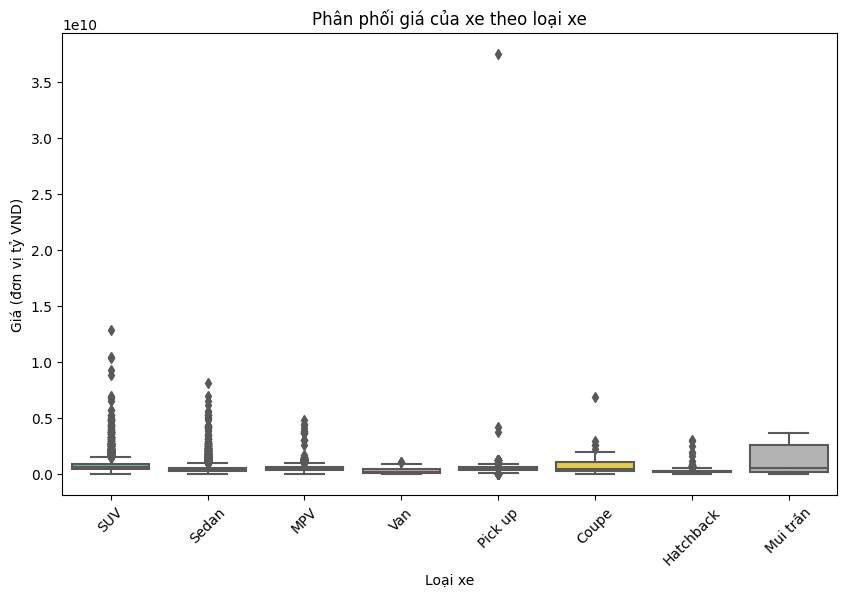

In [371]:
# Lọc dữ liệu cho các loại xe SUV và Sedan
suv_data = df[df['CarType'] == 'SUV']
sedan_data = df[df['CarType'] == 'Sedan']

# Tạo biểu đồ boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='CarType', y='Price', data=df, palette='Set2')
plt.title('Phân phối giá của xe theo loại xe')
plt.ylabel('Giá (đơn vị tỷ VND)')
plt.xlabel('Loại xe')
plt.xticks(rotation=45)  # Xoay nhãn trên trục x để đỡ chồng lên nhau

# Hiển thị biểu đồ
plt.show()


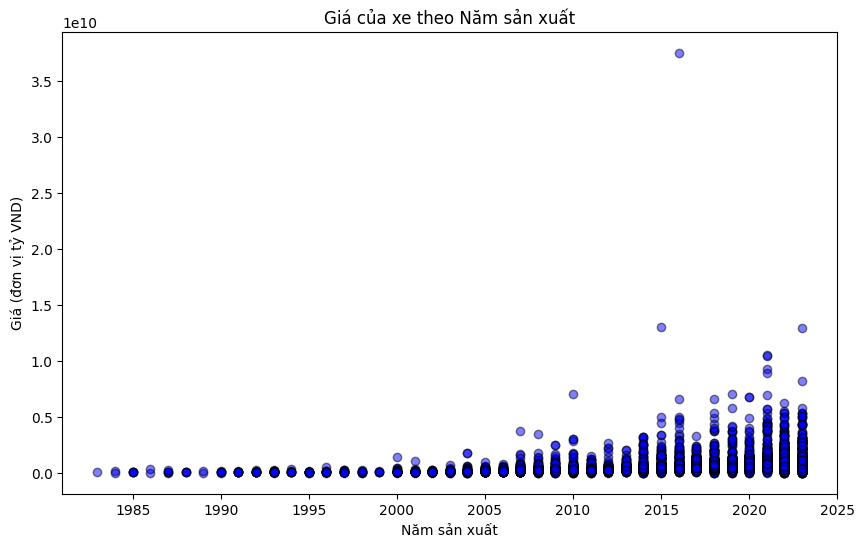

In [372]:
# Tạo biểu đồ scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df['MfgDate'], df['Price'], alpha=0.5, c='b', edgecolors='k')
plt.title('Giá của xe theo Năm sản xuất')
plt.xlabel('Năm sản xuất')
plt.ylabel('Giá (đơn vị tỷ VND)')

# Hiển thị biểu đồ
plt.show()

## **3. Trích chọn đặc trưng**

### **3.1. Tiền xử lý dữ liệu**
#### **Xử lý dữ liệu trống**

In [373]:
df.head()

,Price,CarBrand,CarModel,MfgDate,Mileage,Condition,GearBox,Fuel,CarOrigin,CarType,CarSeats,WarrantyPolicy
0,9.400000e+08,Vinfast,VF8,2023.0,0.0,Mới,Tự động,Điện,Việt Nam,SUV,5.0,Bảo hành hãng
1,9.990000e+08,Hyundai,Santa Fe,2021.0,20000.0,Đã sử dụng,Tự động,Xăng,Việt Nam,SUV,7.0,Bảo hành hãng
2,1.058000e+09,Hyundai,Santa Fe,2021.0,24000.0,Đã sử dụng,Tự động,Dầu,NaN,SUV,7.0,Bảo hành hãng
3,4.600000e+08,Mazda,3,2018.0,44658.0,Đã sử dụng,Tự động,Xăng,Việt Nam,Sedan,5.0,Bảo hành hãng
4,4.150000e+08,Lexus,GS,2007.0,135000.0,Đã sử dụng,Tự động,Xăng,Mỹ,Sedan,4.0,Bảo hành hãng


In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12869 entries, 0 to 12868
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           12866 non-null  float64
 1   CarBrand        12817 non-null  object 
 2   CarModel        12868 non-null  object 
 3   MfgDate         12851 non-null  float64
 4   Mileage         12734 non-null  float64
 5   Condition       12869 non-null  object 
 6   GearBox         12814 non-null  object 
 7   Fuel            12869 non-null  object 
 8   CarOrigin       10258 non-null  object 
 9   CarType         11898 non-null  object 
 10  CarSeats        12506 non-null  float64
 11  WarrantyPolicy  12869 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.2+ MB


In [375]:
df.describe()

,Price,MfgDate,Mileage,CarSeats
count,1.286600e+04,12851.000000,12734.000000,12506.000000
mean,6.025604e+08,2016.771613,63601.195304,5.700624
std,6.848862e+08,5.994100,94014.094990,1.711899
min,5.000000e+06,1983.000000,0.000000,2.000000
25%,3.000000e+08,2014.000000,10000.000000,5.000000
50%,4.790000e+08,2018.000000,47000.000000,5.000000
75%,6.990000e+08,2021.000000,85000.000000,7.000000
max,3.750000e+10,2023.000000,999999.000000,16.000000


In [376]:
# kiểm tra số dữ liệu bị trống
print(df.isnull().sum())

Price                3
CarBrand            52
CarModel             1
MfgDate             18
Mileage            135
Condition            0
GearBox             55
Fuel                 0
CarOrigin         2611
CarType            971
CarSeats           363
WarrantyPolicy       0
dtype: int64


**xử lý các giá trị xuất xứ (CarOrigin) bị trống**
nhận thấy ảnh hưởng của nơi sản xuất đến các xe là không nhiều (một hãng xe có nhiều nơi sản xuất), nên lựa chọn giá trị nhiều nhất để điền vào các giá trị bị thiếu

In [377]:
df['CarOrigin'].value_counts()

Việt Nam      5215
Thái Lan      1527
Hàn Quốc       874
Nhật Bản       827
Nước khác      805
Đức            400
Mỹ             396
Ấn Độ          135
Trung Quốc      47
Đài Loan        32
Name: CarOrigin, dtype: int64

In [378]:
# Thay thế giá trị None (hoặc giá trị trống) bằng giá trị mode của đặc trưng
mode_value = df['CarOrigin'].mode()[0]  # Lấy giá trị mode
df['CarOrigin'].fillna(mode_value, inplace=True)

In [379]:
df['CarOrigin'].value_counts()

Việt Nam      7826
Thái Lan      1527
Hàn Quốc       874
Nhật Bản       827
Nước khác      805
Đức            400
Mỹ             396
Ấn Độ          135
Trung Quốc      47
Đài Loan        32
Name: CarOrigin, dtype: int64

**xử lý các giá trị số chỗ (CarSeats) bị trống**
vì giá trị bị trống khoảng 3% nên lựa chọn giá trị giá trị nhiều nhất (5 chỗ) của đặc trưng đề điền

In [380]:
df['CarSeats'].value_counts()

5.0     8007
7.0     2698
8.0      784
2.0      355
4.0      278
16.0     159
6.0      104
9.0      103
10.0      17
12.0       1
Name: CarSeats, dtype: int64

In [381]:
# điền giá trị none cho đặc trưng carseats
# sử dụng giá trị xuất hiện nhiều nhất để điền
mode_value = df['CarSeats'].mode()[0]  # Lấy giá trị mode
df['CarSeats'].fillna(mode_value, inplace=True)

In [382]:
df['CarSeats'].value_counts()

5.0     8370
7.0     2698
8.0      784
2.0      355
4.0      278
16.0     159
6.0      104
9.0      103
10.0      17
12.0       1
Name: CarSeats, dtype: int64

**thực hiện điền giá trị thiếu vào các đặc trưng: CarBrand, MfgDate, Mileage, GearBox**
vì số lượng các giá trị bị thiếu của các đặc trưng này là rất ít ~1%, nên điền chúng một cách ngẫu nhiên

In [383]:
df["CarBrand"].fillna(random.choice(df[df["CarBrand"] != np.nan]["CarBrand"]), inplace=True)
df["MfgDate"].fillna(random.choice(df[df["MfgDate"] != np.nan]["MfgDate"]), inplace=True)
df["Mileage"].fillna(random.choice(df[df["Mileage"] != np.nan]["Mileage"]), inplace=True)
df["GearBox"].fillna(random.choice(df[df["GearBox"] != np.nan]["GearBox"]), inplace=True)

In [384]:
num_imputer = SimpleImputer(strategy='mean')
df[['Price']] = num_imputer.fit_transform(df[['Price']])

In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12869 entries, 0 to 12868
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           12869 non-null  float64
 1   CarBrand        12869 non-null  object 
 2   CarModel        12868 non-null  object 
 3   MfgDate         12869 non-null  float64
 4   Mileage         12869 non-null  float64
 5   Condition       12869 non-null  object 
 6   GearBox         12869 non-null  object 
 7   Fuel            12869 non-null  object 
 8   CarOrigin       12869 non-null  object 
 9   CarType         11898 non-null  object 
 10  CarSeats        12869 non-null  float64
 11  WarrantyPolicy  12869 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.2+ MB


**điền giá trị thiếu cho đặc trưng phân khúc xe**
phân khúc xe có ảnh hưởng khá lớn với dữ liệu, nên không thể điền các giá trị bị thiếu một cách ngẫu nhiên hoặc bằng giá trị nhiều nhất. vì vậy, ở đây đã sử dung mô hình randomForest với 3 đặc trưng để dự đoán phân khúc xe là: `CarBrand (Hãng xe), CarModel (Dòng xe), CarSeats (Số chỗ ngồi)`

In [386]:


data = df.copy()

# Loại bỏ bất kỳ hàng nào có giá trị "None" trong cột "CarType"
data = data.dropna(subset=["CarType"])

# Loại bỏ bất kỳ hàng nào có giá trị "None" trong cột "CarType"
data = data.dropna(subset=["CarType"])

# Tạo tập dữ liệu đào tạo và kiểm tra
X = data[["CarBrand", "CarModel", "CarSeats"]]
y = data["CarType"]

In [387]:

# Sử dụng One-Hot Encoder để chuyển đổi các cột hạng mục thành các biến giả (dummy variables)
encoder = OneHotEncoder(sparse=False, drop="first", handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)

# Chia dữ liệu thành tập dữ liệu đào tạo và tập dữ liệu kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [388]:
# Sử dụng RandomForestClassifier để xây dựng mô hình
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [389]:
clf.score(X_test, y_test)

0.9105042016806723

In [390]:
# Dự đoán giá trị "None" trong cột "CarType" cho các hàng chưa có dự đoán
X_predict = df[df["CarType"].isna()][["CarBrand", "CarModel", "CarSeats"]]
X_predict_encoded = encoder.transform(X_predict)  # Sử dụng encoder đã được đào tạo

predicted_values = clf.predict(X_predict_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [391]:
# Cập nhật dataframe gốc với dự đoán
df.loc[df["CarType"].isna(), "CarType"] = predicted_values

In [392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12869 entries, 0 to 12868
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           12869 non-null  float64
 1   CarBrand        12869 non-null  object 
 2   CarModel        12868 non-null  object 
 3   MfgDate         12869 non-null  float64
 4   Mileage         12869 non-null  float64
 5   Condition       12869 non-null  object 
 6   GearBox         12869 non-null  object 
 7   Fuel            12869 non-null  object 
 8   CarOrigin       12869 non-null  object 
 9   CarType         12869 non-null  object 
 10  CarSeats        12869 non-null  float64
 11  WarrantyPolicy  12869 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.2+ MB


In [393]:
print(df.isnull().sum())

Price             0
CarBrand          0
CarModel          1
MfgDate           0
Mileage           0
Condition         0
GearBox           0
Fuel              0
CarOrigin         0
CarType           0
CarSeats          0
WarrantyPolicy    0
dtype: int64


In [394]:
df['Condition'].value_counts()

Đã sử dụng    10906
Mới            1963
Name: Condition, dtype: int64

### **3.2. Xử lý ngoại lệ:**

In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12869 entries, 0 to 12868
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           12869 non-null  float64
 1   CarBrand        12869 non-null  object 
 2   CarModel        12868 non-null  object 
 3   MfgDate         12869 non-null  float64
 4   Mileage         12869 non-null  float64
 5   Condition       12869 non-null  object 
 6   GearBox         12869 non-null  object 
 7   Fuel            12869 non-null  object 
 8   CarOrigin       12869 non-null  object 
 9   CarType         12869 non-null  object 
 10  CarSeats        12869 non-null  float64
 11  WarrantyPolicy  12869 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.2+ MB


In [396]:
df['WarrantyPolicy'].unique()


array(['Bảo hành hãng'], dtype=object)

In [397]:
# xoá cột bảo hành vì trong cột chỉ chứa một giá trị duy nhất
df.drop('WarrantyPolicy', axis=1, inplace=True)

In [398]:
numerical_cols = ['Price', 'MfgDate', 'Mileage', 'CarSeats']
X_numerical = df[numerical_cols]

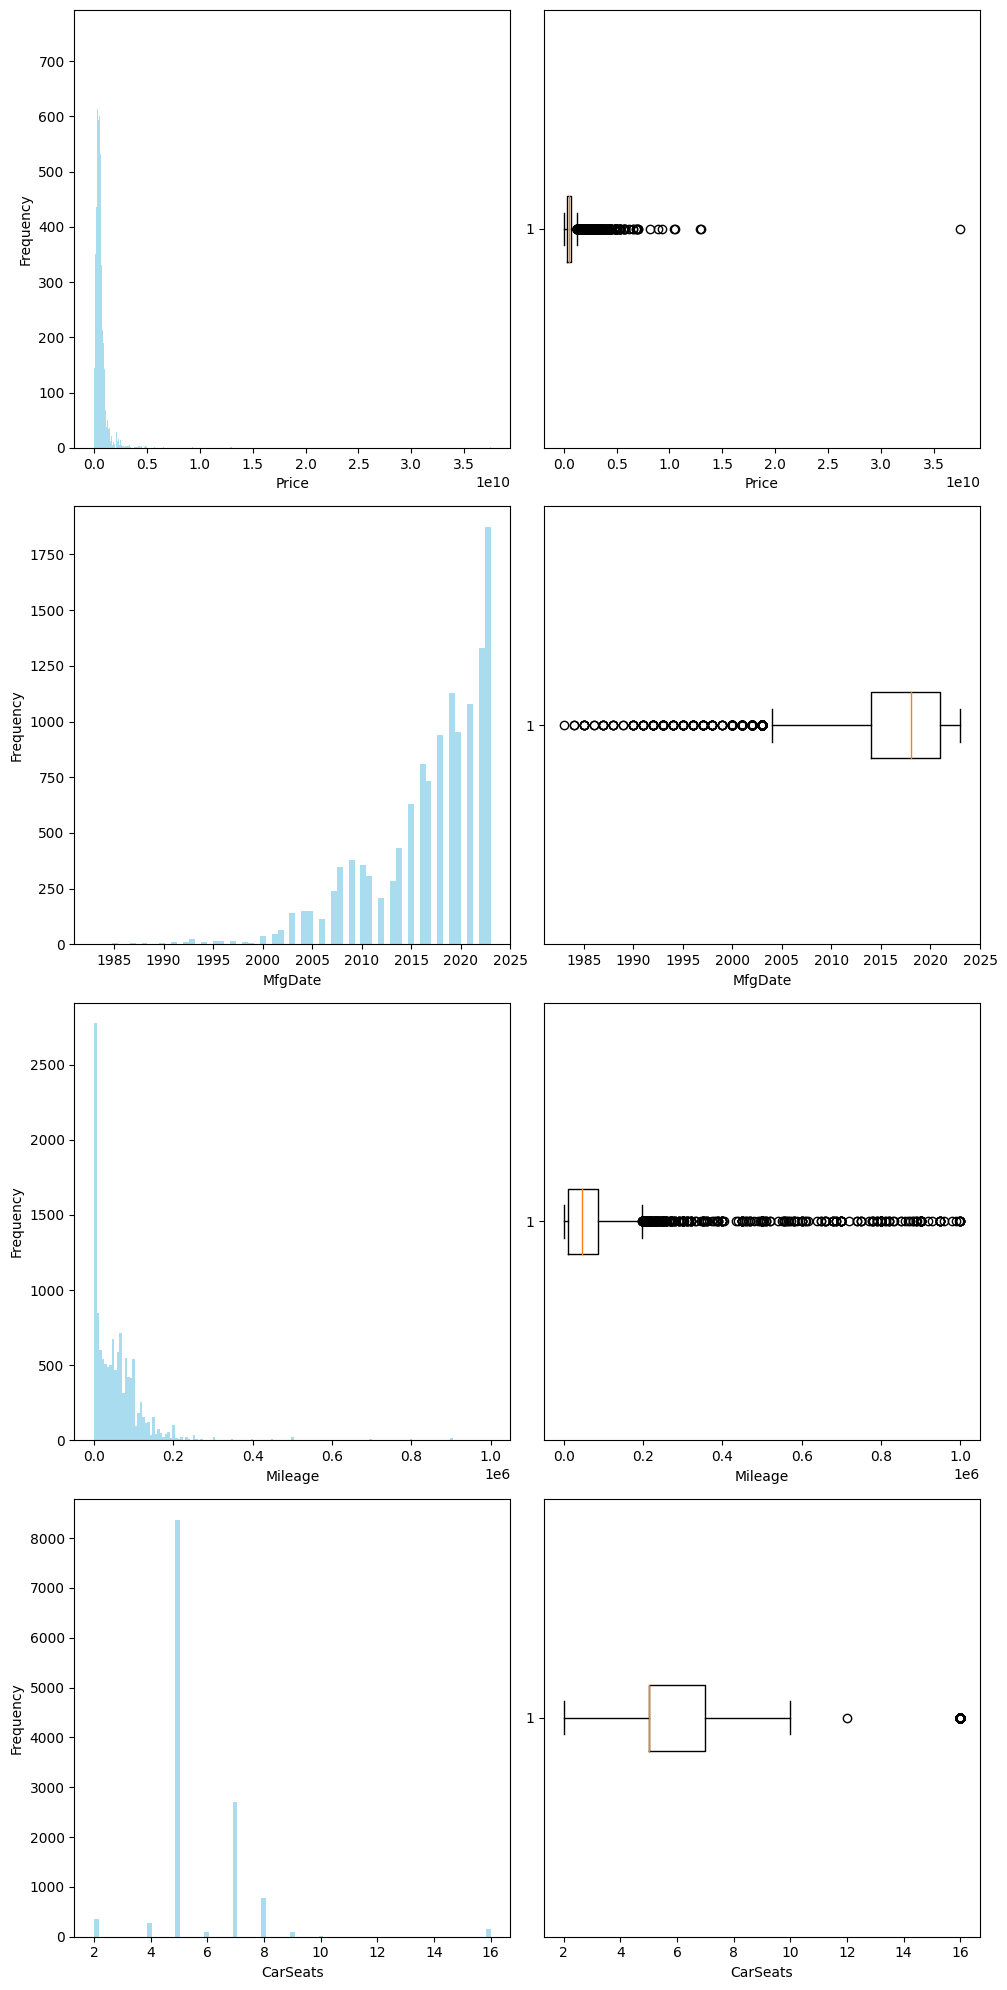

In [399]:
# Plot histograms và boxplots
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=2, figsize=(10, 5 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    # Histogram
    axes[i, 0].hist(X_numerical[col], bins='auto', color='skyblue', alpha=0.7)
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')

    # Boxplot
    axes[i, 1].boxplot(X_numerical[col], vert=False)
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()


In [400]:
# Xác định ngoại lệ trong cột 'Price'
Q1_price = df['Price'].quantile(0.25)
Q3_price = df['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_price = Q1_price - 0.5 * IQR_price
upper_bound_price = Q3_price + 3 * IQR_price

outliers_price = df[(df['Price'] < lower_bound_price) | (df['Price'] > upper_bound_price)]

# In ra các giá trị ngoại lệ
print("Ngoại lệ trong cột 'Price':")
outliers_price = pd.DataFrame(outliers_price)
outliers_price



Ngoại lệ trong cột 'Price':


,Price,CarBrand,CarModel,MfgDate,Mileage,Condition,GearBox,Fuel,CarOrigin,CarType,CarSeats
21,3.000000e+09,Honda,CR V,2010.0,10000.0,Đã sử dụng,Tự động,Xăng,Việt Nam,SUV,5.0
48,5.500000e+07,Suzuki,APV,1997.0,56789.0,Đã sử dụng,Số sàn,Xăng,Nhật Bản,SUV,7.0
49,1.990000e+09,Porsche,Macan,2016.0,50000.0,Đã sử dụng,Tự động,Xăng,Đức,SUV,5.0
50,6.000000e+06,Kia,Dòng khác,2011.0,19999.0,Đã sử dụng,Tự động,Xăng,Việt Nam,Van,2.0
54,9.500000e+07,Honda,Accord,1995.0,121219.0,Đã sử dụng,Số sàn,Xăng,Nhật Bản,Sedan,5.0
...,...,...,...,...,...,...,...,...,...,...,...
12774,4.999000e+09,Mercedes Benz,S Class,2022.0,14.0,Đã sử dụng,Tự động,Xăng,Thái Lan,Sedan,5.0
12818,4.868000e+09,Porsche,Cayenne,2021.0,8000.0,Đã sử dụng,Tự động,Xăng,Việt Nam,SUV,5.0
12839,9.000000e+07,Kia,CD5,2004.0,120000.0,Đã sử dụng,Số sàn,Xăng,Hàn Quốc,Hatchback,5.0
12842,2.500000e+09,Maserati,Levante,2018.0,60000.0,Đã sử dụng,Tự động,Xăng,Nước khác,SUV,5.0


In [401]:
lower_bound_price = Q1_price - 0.5 * IQR_price
lower_bound_price, upper_bound_price

(100500000.0, 1896000000.0)

In [402]:
filtered_df = df[df['Price'] < 50000000]

# In ra các mẫu đã lọc
filtered_df

,Price,CarBrand,CarModel,MfgDate,Mileage,Condition,GearBox,Fuel,CarOrigin,CarType,CarSeats
50,6000000.0,Kia,Dòng khác,2011.0,19999.0,Đã sử dụng,Tự động,Xăng,Việt Nam,Van,2.0
324,29000000.0,Mitsubishi,Attrage,2020.0,130000.0,Đã sử dụng,Số sàn,Xăng,Thái Lan,Sedan,5.0
564,24000000.0,Honda,Accord,1990.0,78000.0,Đã sử dụng,Số sàn,Xăng,Mỹ,Sedan,5.0
589,33000000.0,Toyota,Hiace,2004.0,120000.0,Đã sử dụng,Số sàn,Xăng,Nhật Bản,Van,6.0
637,28000000.0,Toyota,Hiace,2002.0,150000.0,Đã sử dụng,Số sàn,Xăng,Nhật Bản,Van,16.0
...,...,...,...,...,...,...,...,...,...,...,...
12535,48000000.0,Daewoo,Nubira,2001.0,123456.0,Đã sử dụng,Số sàn,Xăng,Việt Nam,Sedan,5.0
12592,35000000.0,Suzuki,Dòng khác,2011.0,147111.0,Đã sử dụng,Số sàn,Xăng,Việt Nam,Van,5.0
12624,25800000.0,Honda,Civic,2007.0,258.0,Đã sử dụng,Tự động,Xăng,Nhật Bản,Sedan,5.0
12713,48500000.0,Toyota,Corolla Altis,2017.0,70000.0,Đã sử dụng,Tự động,Xăng,Nhật Bản,Sedan,5.0


In [403]:
filtered_df = df[df['MfgDate'] < 2000]

# In ra các mẫu đã lọc
filtered_df

,Price,CarBrand,CarModel,MfgDate,Mileage,Condition,GearBox,Fuel,CarOrigin,CarType,CarSeats
31,289898989.0,Mitsubishi,Pajero,1998.0,450000.0,Đã sử dụng,Số sàn,Xăng,Nhật Bản,SUV,7.0
48,55000000.0,Suzuki,APV,1997.0,56789.0,Đã sử dụng,Số sàn,Xăng,Nhật Bản,SUV,7.0
54,95000000.0,Honda,Accord,1995.0,121219.0,Đã sử dụng,Số sàn,Xăng,Nhật Bản,Sedan,5.0
564,24000000.0,Honda,Accord,1990.0,78000.0,Đã sử dụng,Số sàn,Xăng,Mỹ,Sedan,5.0
650,75000000.0,Toyota,Corolla,1991.0,200000.0,Đã sử dụng,Số sàn,Xăng,Mỹ,Sedan,5.0
...,...,...,...,...,...,...,...,...,...,...,...
11700,32000000.0,Asia,Dòng khác,1993.0,99999.0,Đã sử dụng,Tự động,Xăng,Hàn Quốc,MPV,8.0
11783,75000000.0,Mazda,626,1995.0,400000.0,Đã sử dụng,Tự động,Xăng,Nhật Bản,Sedan,5.0
11883,110000000.0,Toyota,Camry,1996.0,122668.0,Đã sử dụng,Tự động,Xăng,Nhật Bản,Sedan,4.0
11890,66000000.0,Toyota,Corolla,1993.0,195000.0,Đã sử dụng,Số sàn,Xăng,Nhật Bản,Sedan,5.0


In [404]:

df = df.drop(outliers_price.index)

In [405]:
df = df.drop(df[df['MfgDate'] < 2000].index)

# Tìm các hàng thỏa mãn điều kiện và lấy chỉ số của chúng
condition = (df['Mileage'] > 300000) & ((2023 - df['MfgDate']) < 10)

# Sử dụng phương thức drop để xoá các hàng
df = df.drop(df[condition].index)

In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11705 entries, 0 to 12868
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      11705 non-null  float64
 1   CarBrand   11705 non-null  object 
 2   CarModel   11704 non-null  object 
 3   MfgDate    11705 non-null  float64
 4   Mileage    11705 non-null  float64
 5   Condition  11705 non-null  object 
 6   GearBox    11705 non-null  object 
 7   Fuel       11705 non-null  object 
 8   CarOrigin  11705 non-null  object 
 9   CarType    11705 non-null  object 
 10  CarSeats   11705 non-null  float64
dtypes: float64(4), object(7)
memory usage: 1.1+ MB


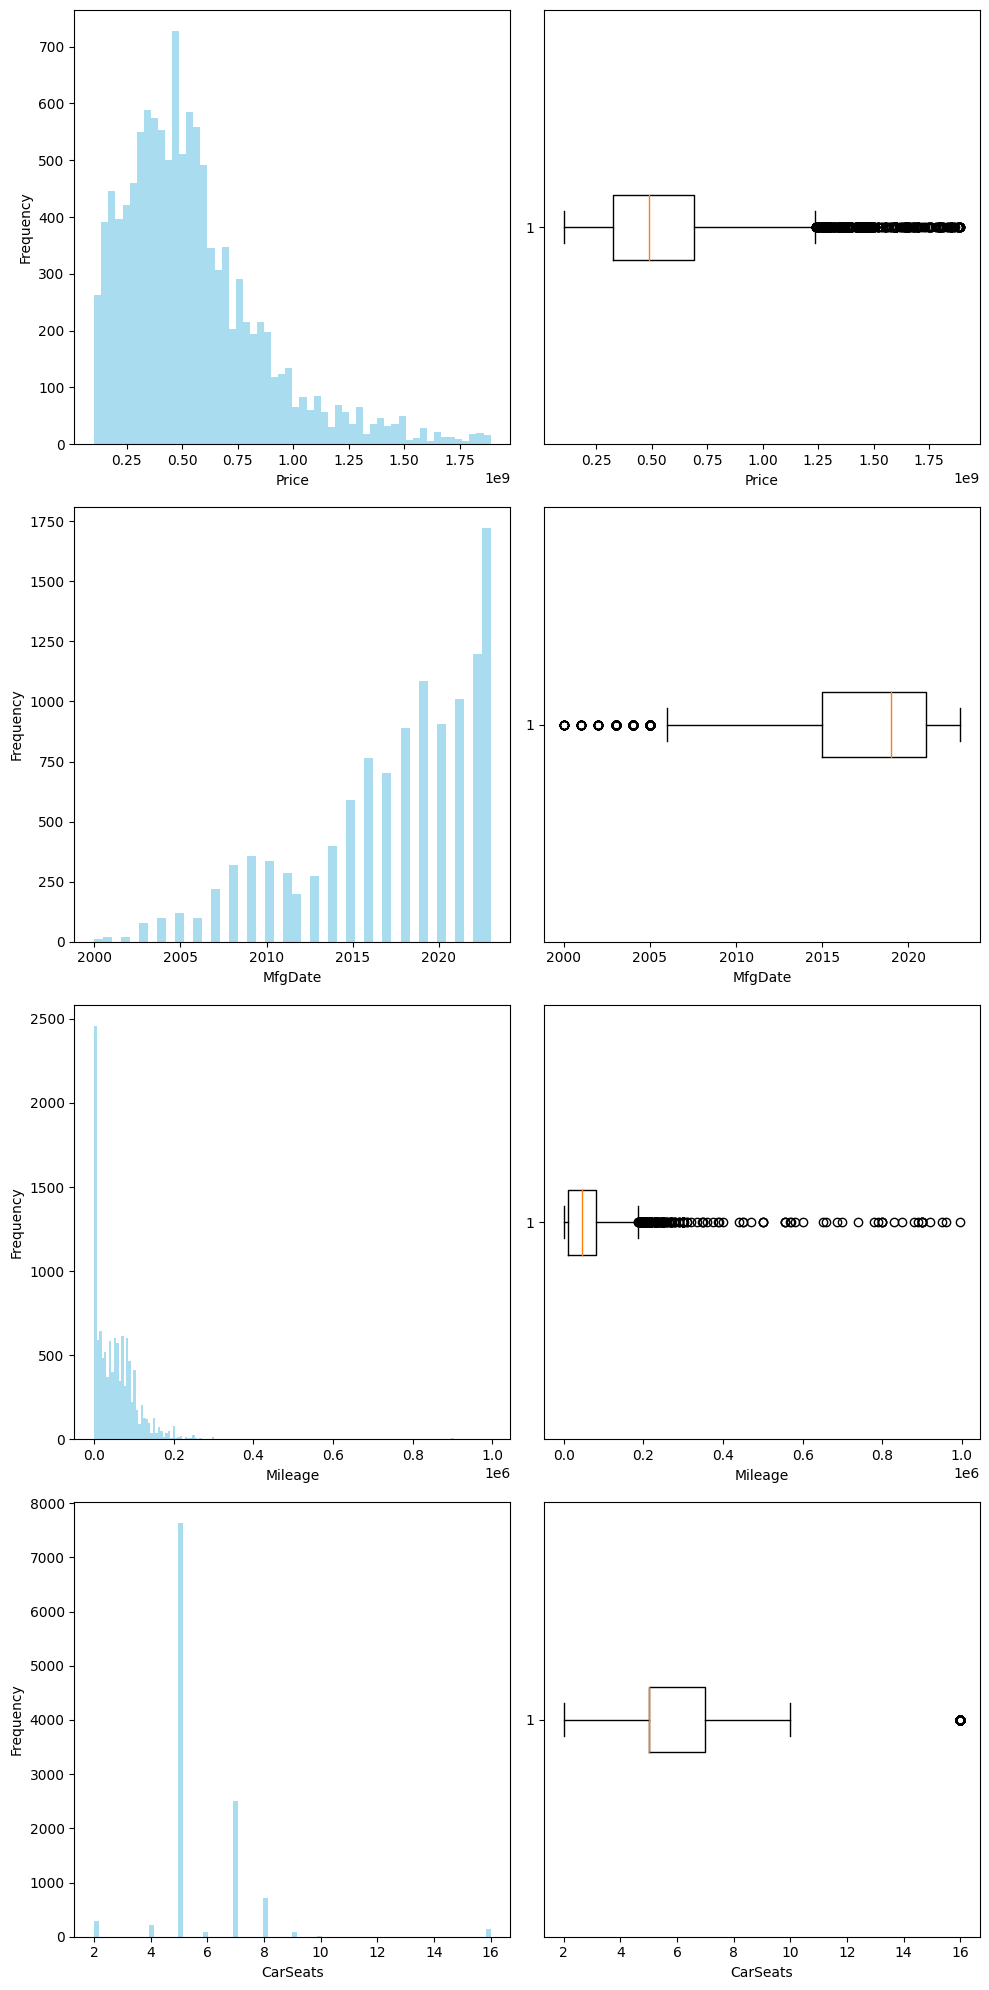

In [407]:
numerical_cols = ['Price', 'MfgDate', 'Mileage', 'CarSeats']
X_numerical = df[numerical_cols]

# Plot histograms và boxplots
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=2, figsize=(10, 5 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    # Histogram
    axes[i, 0].hist(X_numerical[col], bins='auto', color='skyblue', alpha=0.7)
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')

    # Boxplot
    axes[i, 1].boxplot(X_numerical[col], vert=False)
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()


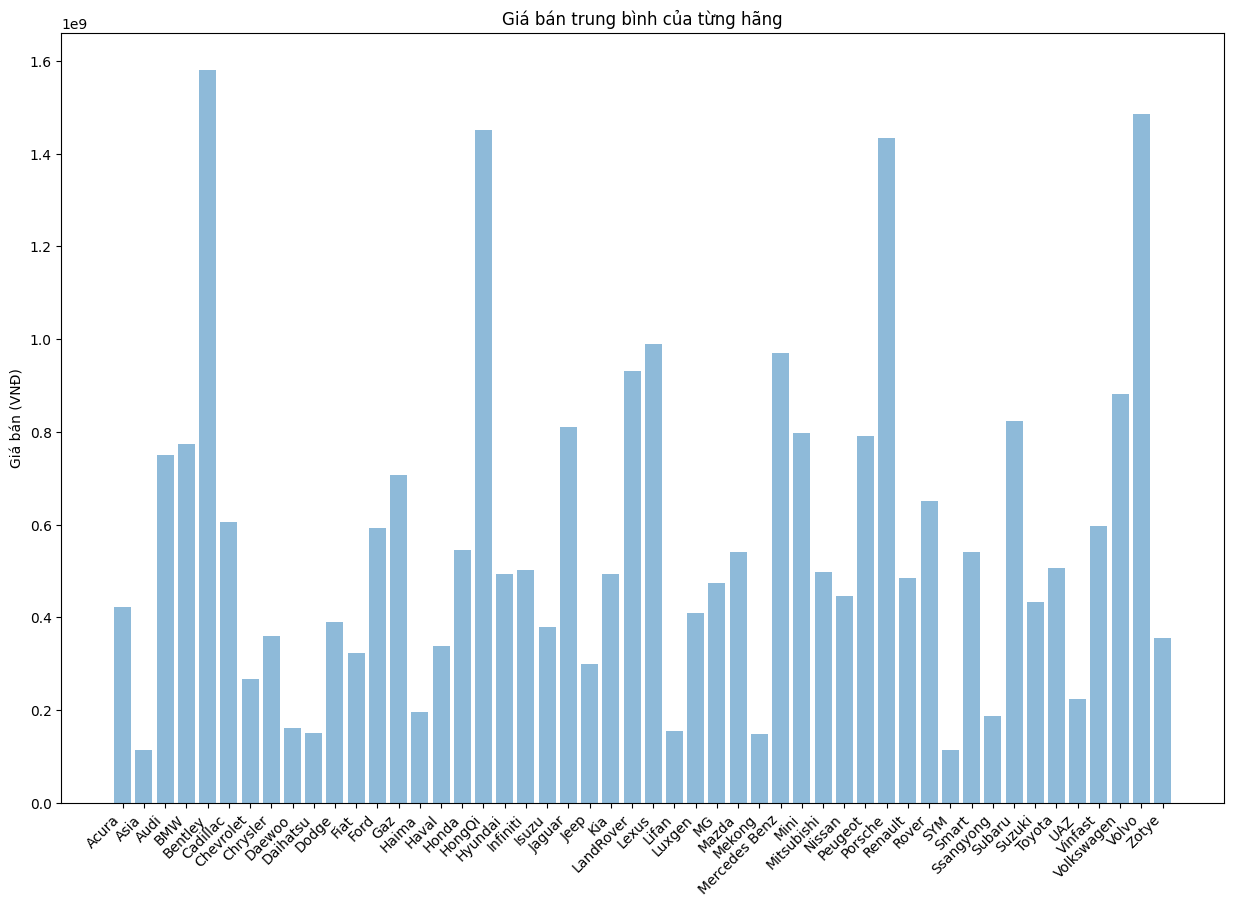

In [408]:
price_brand = df.groupby("CarBrand").mean()["Price"]
price_brand.index
plt.figure(figsize=(15,10))
plt.bar(price_brand.index, price_brand, align='center', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Giá bán (VNĐ)')
plt.title('Giá bán trung bình của từng hãng')
plt.show()

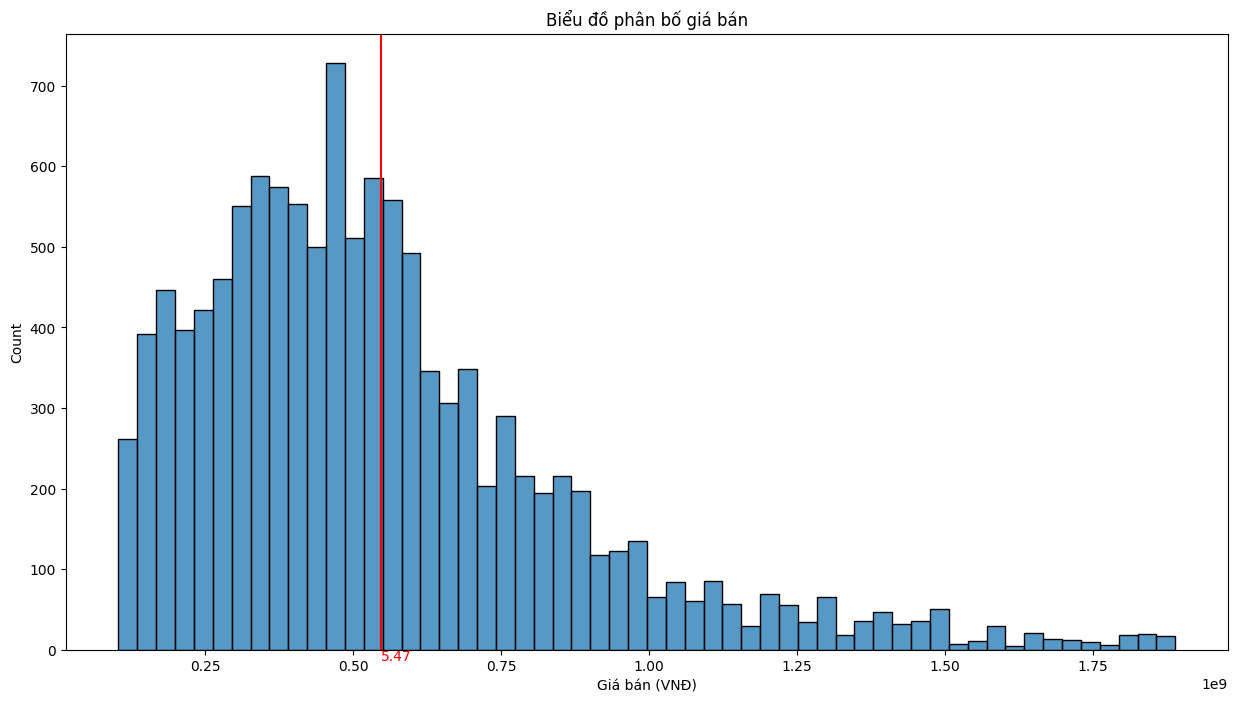

In [409]:
price_sale = df["Price"].dropna()
price_mean = price_sale.mean()
plt.figure(figsize=(15,8))
sns.histplot(data=price_sale)
plt.axvline(price_mean, color='r')
plt.xlabel('Giá bán (VNĐ)')
plt.title("Biểu đồ phân bố giá bán")
_price_mean = price_mean / 1e8
plt.text(price_mean, 0, f'{_price_mean:.2f}', color='r', verticalalignment='top', horizontalalignment='left')
plt.show()


In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11705 entries, 0 to 12868
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      11705 non-null  float64
 1   CarBrand   11705 non-null  object 
 2   CarModel   11704 non-null  object 
 3   MfgDate    11705 non-null  float64
 4   Mileage    11705 non-null  float64
 5   Condition  11705 non-null  object 
 6   GearBox    11705 non-null  object 
 7   Fuel       11705 non-null  object 
 8   CarOrigin  11705 non-null  object 
 9   CarType    11705 non-null  object 
 10  CarSeats   11705 non-null  float64
dtypes: float64(4), object(7)
memory usage: 1.1+ MB


In [411]:
## lưu dữ liệu đã làm sạch

df.to_csv('/content/drive/MyDrive/web_crawler/data/processing_car.csv', index=False, encoding='utf-8')

### **3.3. Chuẩn hoá dữ liệu**

In [412]:
df = pd.read_csv("/content/drive/MyDrive/web_crawler/data/processing_car.csv")
df.head(5)

,Price,CarBrand,CarModel,MfgDate,Mileage,Condition,GearBox,Fuel,CarOrigin,CarType,CarSeats
0,9.400000e+08,Vinfast,VF8,2023.0,0.0,Mới,Tự động,Điện,Việt Nam,SUV,5.0
1,9.990000e+08,Hyundai,Santa Fe,2021.0,20000.0,Đã sử dụng,Tự động,Xăng,Việt Nam,SUV,7.0
2,1.058000e+09,Hyundai,Santa Fe,2021.0,24000.0,Đã sử dụng,Tự động,Dầu,Việt Nam,SUV,7.0
3,4.600000e+08,Mazda,3,2018.0,44658.0,Đã sử dụng,Tự động,Xăng,Việt Nam,Sedan,5.0
4,4.150000e+08,Lexus,GS,2007.0,135000.0,Đã sử dụng,Tự động,Xăng,Mỹ,Sedan,4.0


In [413]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11705 entries, 0 to 11704
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      11705 non-null  float64
 1   CarBrand   11705 non-null  object 
 2   CarModel   11704 non-null  object 
 3   MfgDate    11705 non-null  float64
 4   Mileage    11705 non-null  float64
 5   Condition  11705 non-null  object 
 6   GearBox    11705 non-null  object 
 7   Fuel       11705 non-null  object 
 8   CarOrigin  11705 non-null  object 
 9   CarType    11705 non-null  object 
 10  CarSeats   11705 non-null  float64
dtypes: float64(4), object(7)
memory usage: 1006.0+ KB


In [414]:


# # Chọn các cột dữ liệu phân loại cần mã hóa
# categorical_columns = ['CarBrand', 'CarModel', 'Condition', 'GearBox', 'Fuel', 'CarOrigin', 'CarType']

# df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# df_categorical = df.drop(['Price', 'MfgDate', 'Mileage', 'CarSeats'], axis=1)
# df_numerical = df[['Price', 'MfgDate', 'Mileage', 'CarSeats']]


# # Sử dụng StandardScaler để chuẩn hoá các biến số
# scaler = StandardScaler()
# df_numerical = scaler.fit_transform(df_numerical)
# df_numerical = pd.DataFrame(df_numerical)

# df = pd.concat([df_numerical, df_categorical], ignore_index=False, sort=False, axis=1)
# df = df.rename(columns={0: 'Price', 1: 'MfgDate', 2: 'Mileage', 3: 'CarSeats'})



In [415]:
# y = df['Price']
# df = df.drop('Price', axis = 1)



# # Chọn các cột dữ liệu phân loại cần mã hóa
# categorical_columns = ['CarBrand', 'CarModel', 'Condition', 'GearBox', 'Fuel', 'CarOrigin', 'CarType']

# df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# df_categorical = df.drop(['MfgDate', 'Mileage', 'CarSeats'], axis=1)
# df_numerical = df[['MfgDate', 'Mileage', 'CarSeats']]


# # Sử dụng StandardScaler để chuẩn hoá các biến số
# scaler = StandardScaler()
# df_numerical = scaler.fit_transform(df_numerical)
# df_numerical = pd.DataFrame(df_numerical)

# df = pd.concat([df_numerical, df_categorical], ignore_index=False, sort=False, axis=1)
# df = df.rename(columns={0: 'MfgDate', 1: 'Mileage', 2: 'CarSeats'})

# X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.75, random_state=42)

In [416]:
y = df['Price']
df = df.drop('Price', axis = 1)



# Chọn các cột dữ liệu phân loại cần mã hóa
categorical_columns = ['CarBrand', 'CarModel', 'Condition', 'GearBox', 'Fuel', 'CarOrigin', 'CarType']

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.8, random_state=42)

In [417]:

encoded_columns = df.columns
encoded_columns



Index(['MfgDate', 'Mileage', 'CarSeats', 'CarBrand_Asia', 'CarBrand_Audi',
       'CarBrand_BMW', 'CarBrand_Bentley', 'CarBrand_Cadillac',
       'CarBrand_Chevrolet', 'CarBrand_Chrysler',
       ...
       'CarOrigin_Đài Loan', 'CarOrigin_Đức', 'CarOrigin_Ấn Độ',
       'CarType_Hatchback', 'CarType_MPV', 'CarType_Mui trần',
       'CarType_Pick up', 'CarType_SUV', 'CarType_Sedan', 'CarType_Van'],
      dtype='object', length=414)

In [418]:
joblib.dump(encoded_columns, '/content/drive/MyDrive/web_crawler/encoded_columns.pkl')

['/content/drive/MyDrive/web_crawler/encoded_columns.pkl']

In [207]:
df.head()

,MfgDate,Mileage,CarSeats,CarBrand_Asia,CarBrand_Audi,CarBrand_BMW,CarBrand_Bentley,CarBrand_Cadillac,CarBrand_Chery,CarBrand_Chevrolet,...,CarOrigin_Đài Loan,CarOrigin_Đức,CarOrigin_Ấn Độ,CarType_Hatchback,CarType_MPV,CarType_Mui trần,CarType_Pick up,CarType_SUV,CarType_Sedan,CarType_Van
0,2023.0,0.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2021.0,20000.0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2021.0,24000.0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2018.0,44658.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2007.0,135000.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [208]:
# y = df['Price']
# X = df.drop('Price', axis = 1)

In [209]:
# rg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# models, preds = rg.fit(X_train, X_test, y_train, y_test)

In [210]:
# # Tạo danh sách tên mô hình
# model_names = models.index.tolist()

# # Thêm danh sách tên mô hình thành một cột 'Model' trong DataFrame
# models['Model'] = model_names

# # Ghi DataFrame vào file CSV
# models.to_csv('/content/drive/MyDrive/web_crawler/data/models_compare.csv', index=False, encoding='utf-8')

# # Hiển thị DataFrame
# print(model_names)

In [211]:
# models

## **4. Mô hình hoá dữ liệu**
### **4.1. Random forest**

In [419]:
model = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 1, 2, 3],
}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)
# Fit mô hình trên tập train và validation
grid_search.fit(X_train, y_train)
# In ra siêu tham số tốt nhất và điểm số tương ứng
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score (Negative MAE): ", grid_search.best_score_)

Best Hyperparameters:  {'max_depth': None, 'n_estimators': 200}
Best Score (Negative MAE):  -59665624.238723576


In [213]:
class ModelRandomForestRegressor:

    def __init__(self, model=None):
        if model == None:
            self.model = RandomForestRegressor()
        else:
            self.model = model

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred

    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_test, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_test, y_pred)
        self.score_r2 = r2_score(y_test, y_pred)

        print(f"MAE: {self.score_mae:.05f}")
        print(f"RMSE: {self.score_rmse:.05f}")
        print(f"MAPE: {self.score_mape:.05f}")
        print(f"R2_SQUARE: {self.score_r2:.05f}")

        return self.score_mae, self.score_rmse, self.score_mape, self.score_r2

    def plot_line(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(0, X_test[0:100].shape[0]), y=self.y_pred[0:100], ax=ax, color='red', label='Giá trị dự đoán')
        sns.lineplot(x=range(0, X_test[0:100].shape[0]), y=y_test[0:100], ax=ax, color='green', label='Giá trị thực tế')

        ax.set_title('Biểu đồ đường giá xe dự đoán và thực thế')
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_scatter(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Giá thực tế')
        plt.ylabel('Giá dự đoán')
        plt.title('Biểu đồ phân tán giá xe dự đoán và thực thế')
        plt.show()

    def plot_residuals(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        residuals = y_pred - y_test

        # Vẽ biểu đồ Residuals
        plt.scatter(y_test, residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Price')
        plt.ylabel('Residuals')
        plt.title('Biểu đồ dư thừa giá xe dự đoán và thực tế')
        plt.show()

MAE: 56982824.83481
RMSE: 124206578.08158
MAPE: 0.13793
R2_SQUARE: 0.85335


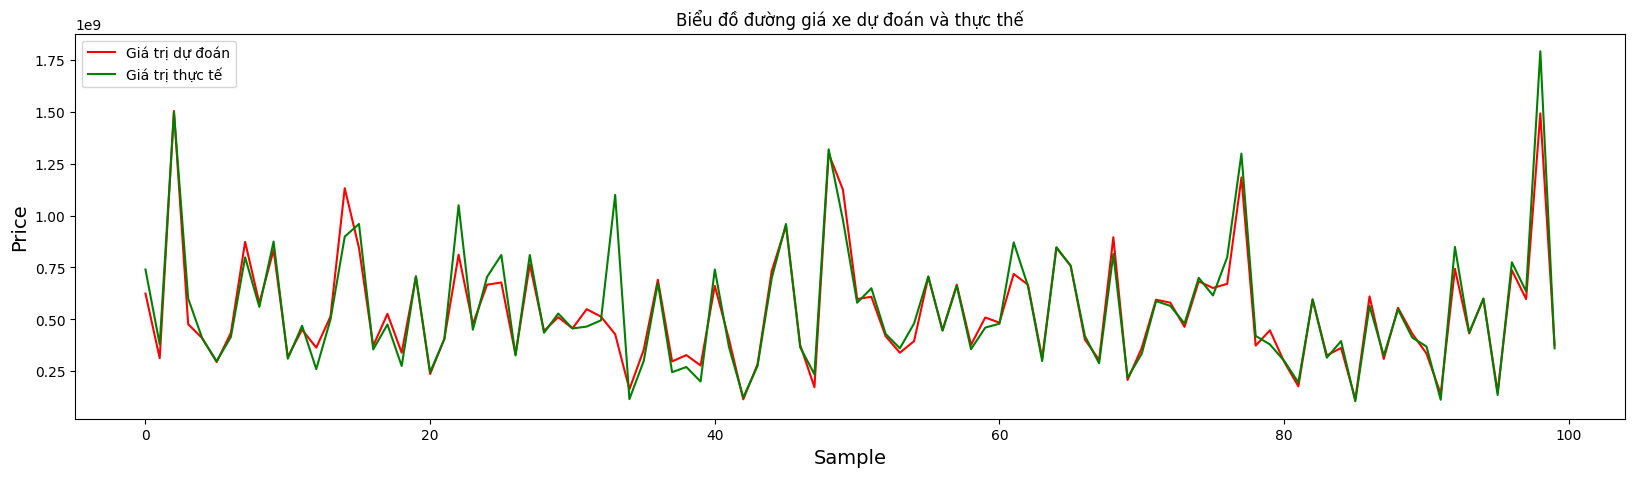

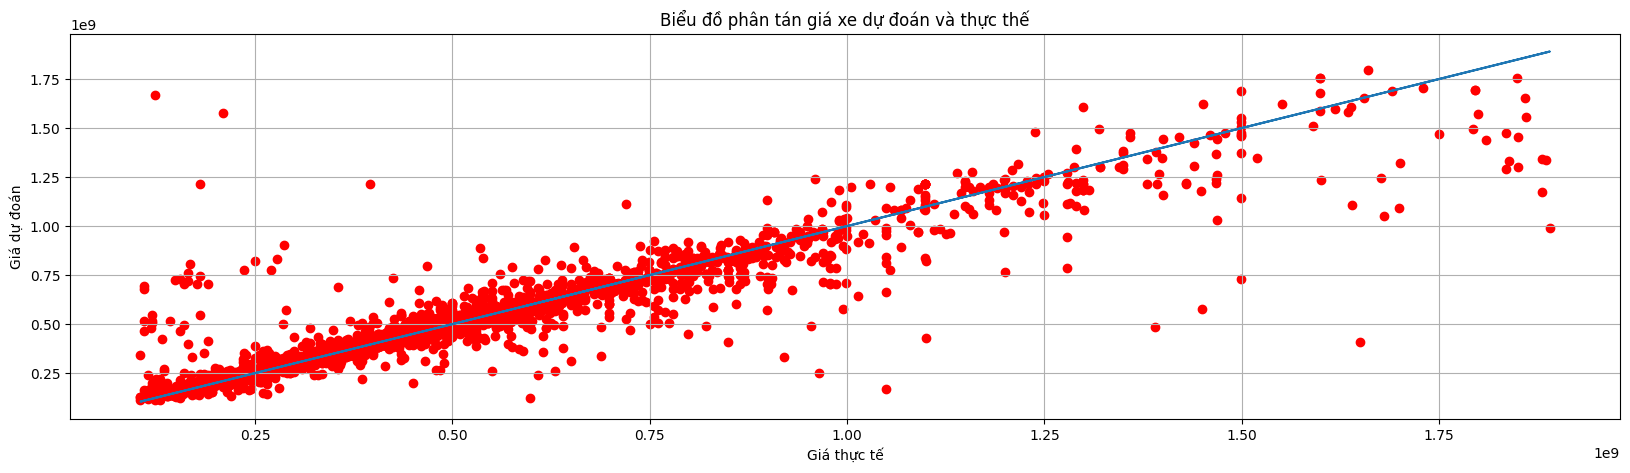

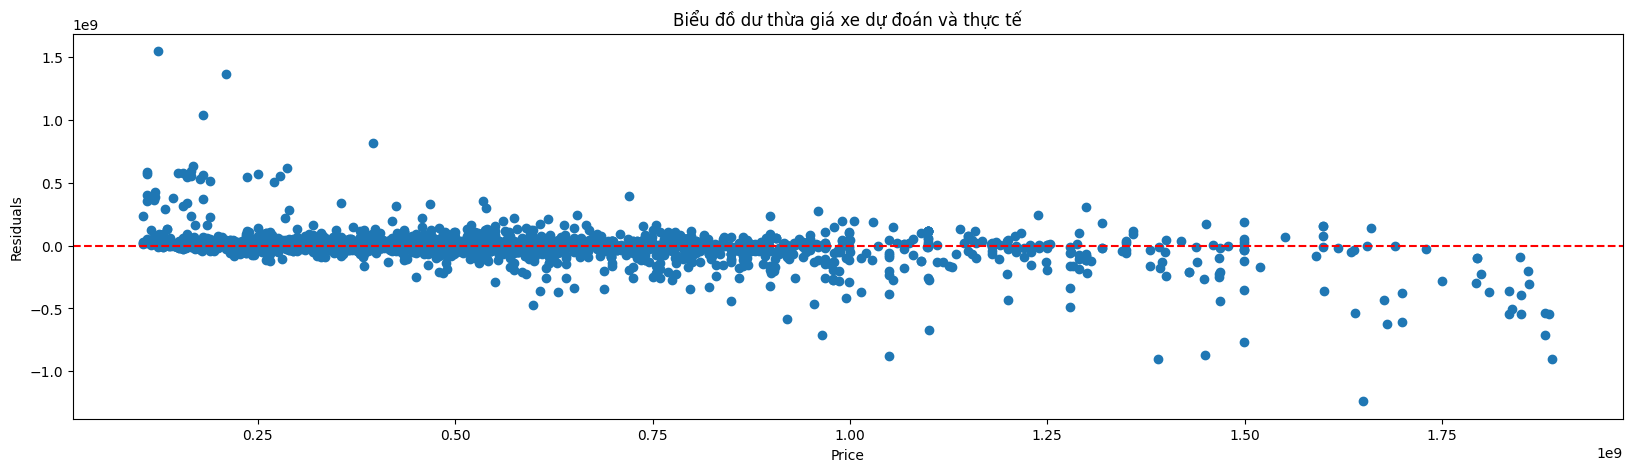

In [420]:
model = RandomForestRegressor(**grid_search.best_params_)
rf_reg = ModelRandomForestRegressor(model)
rf_reg.train(X_train, y_train)
rf_y_pred = rf_reg.predict(X_test)
rf_score_mae, rf_score_rmse, rf_score_mape, rf_r2 = rf_reg.evaluate(y_test, rf_y_pred)
rf_reg.plot_line(20, 5, X_test, y_test)
rf_reg.plot_scatter(20, 5, rf_y_pred, y_test)
rf_reg.plot_residuals(20, 5, rf_y_pred, y_test)

In [421]:
joblib.dump(model, '/content/drive/MyDrive/web_crawler/random_forest_model.pkl')

['/content/drive/MyDrive/web_crawler/random_forest_model.pkl']

In [ ]:
loaded_model = joblib.load('/content/drive/MyDrive/web_crawler/random_forest_model.pkl')
y_pred = loaded_model.predict(X_test)

# Evaluate the model
score_mae = mean_absolute_error(y_test, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
score_mape = mean_absolute_percentage_error(y_test, y_pred)
score_r2 = r2_score(y_test, y_pred)

print(f"MAE: {score_mae:.05f}")
print(f"RMSE: {score_rmse:.05f}")
print(f"MAPE: {score_mape:.05f}")
print(f"R2_SQUARE: {score_r2:.05f}")

MAE: 58593002.56659
RMSE: 124083820.80268
MAPE: 0.15639
R2_SQUARE: 0.85430


In [424]:
loaded_model = joblib.load('/content/drive/MyDrive/web_crawler/random_forest_model.pkl')
encoded_columns = joblib.load('/content/drive/MyDrive/web_crawler/encoded_columns.pkl')

In [433]:
# Tạo DataFrame cho dữ liệu mới với cùng cấu trúc cột phân loại
new_data = pd.DataFrame({
    'Price': [3.8e8],
    'CarBrand': ['Toyota'],
    'CarModel': ['Vios'],
    'MfgDate': [2015.0],
    'Mileage': [72000.0],
    'Condition': ['Đã sử dụng'],
    'GearBox': ['Số sàn'],
    'Fuel': ['Xăng'],
    'CarOrigin': ['Thái Lan'],
    'CarType': ['Sedan'],
    'CarSeats': [5.0]
})

categorical_columns = ['CarBrand', 'CarModel', 'Condition', 'GearBox', 'Fuel', 'CarOrigin', 'CarType']
new_data_encoded = pd.get_dummies(new_data, columns=categorical_columns)

new_data_encoded = new_data_encoded.reindex(columns=encoded_columns, fill_value=0)

In [ ]:
new_data_encoded

,MfgDate,Mileage,CarSeats,CarBrand_Asia,CarBrand_Audi,CarBrand_BMW,CarBrand_Bentley,CarBrand_Cadillac,CarBrand_Chevrolet,CarBrand_Chrysler,...,CarOrigin_Đài Loan,CarOrigin_Đức,CarOrigin_Ấn Độ,CarType_Hatchback,CarType_MPV,CarType_Mui trần,CarType_Pick up,CarType_SUV,CarType_Sedan,CarType_Van
0,2020.0,15000.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [434]:
new = loaded_model.predict(new_data_encoded)
new

array([2.50062778e+08])

array([4.0651125e+08])

### 4.2. Linear regression

MAE: 87444008.02615
RMSE: 146974531.92649
MAPE: 0.22963
R2_SQUARE: 0.79466


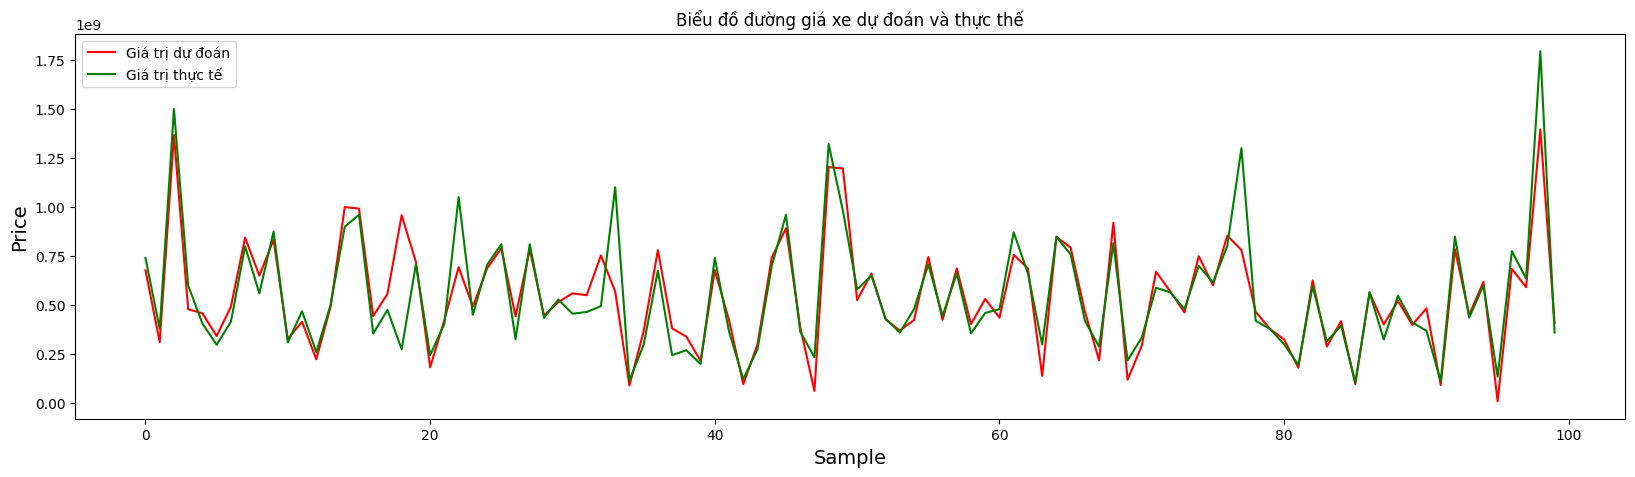

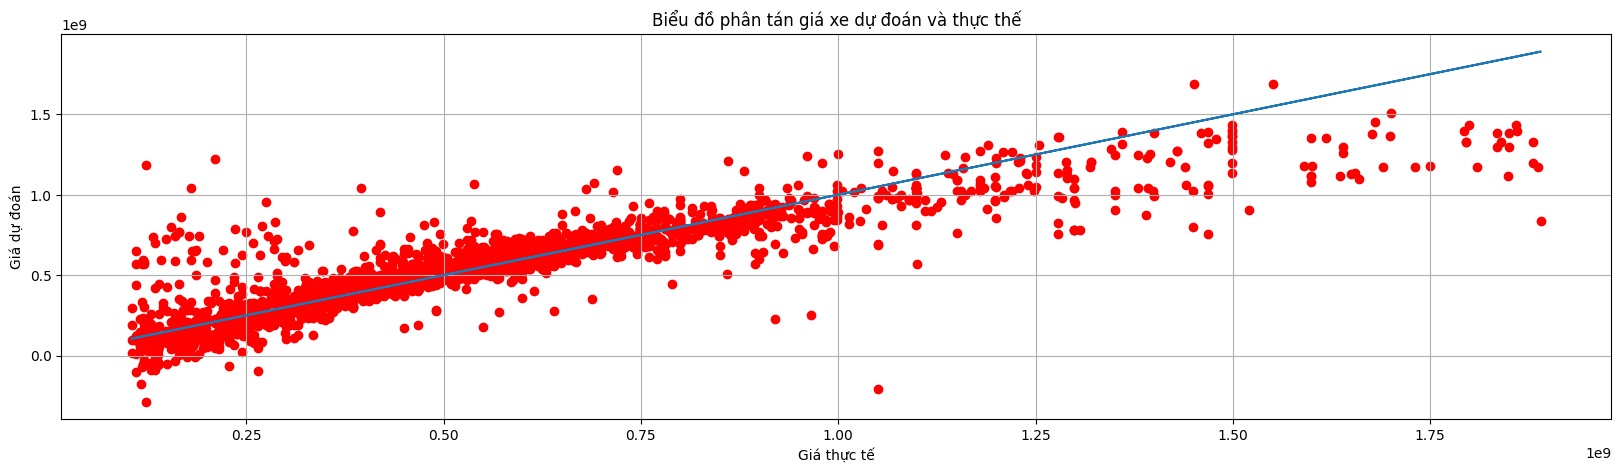

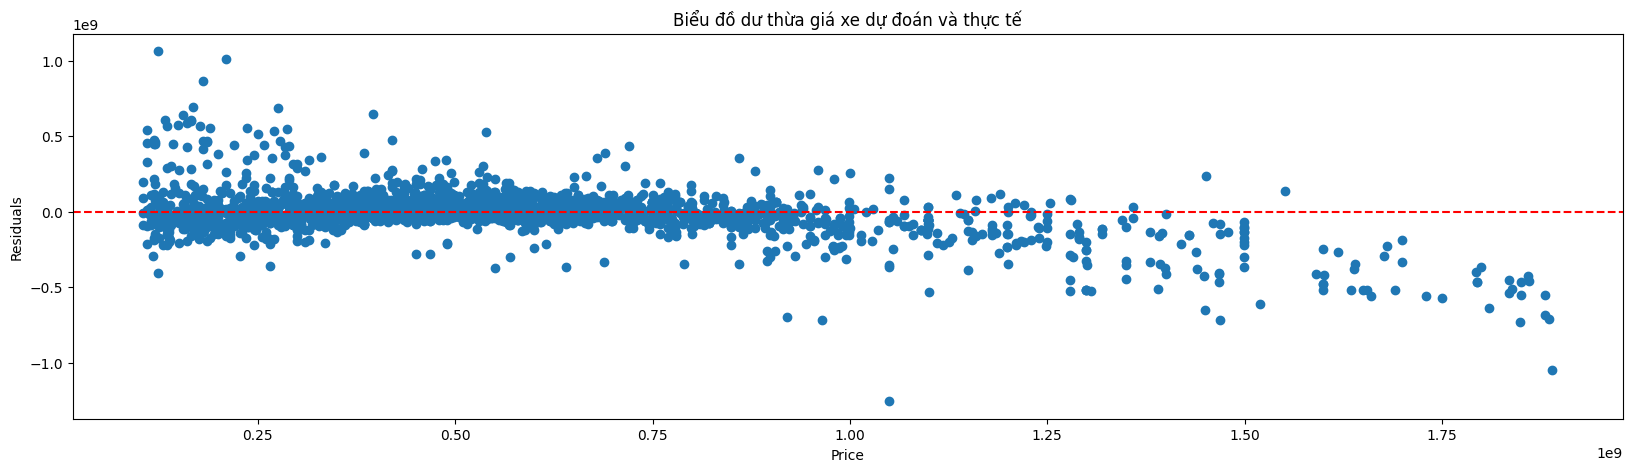

In [ ]:
from sklearn.linear_model import LinearRegression

class ModelLinearRegressor:

    def __init__(self, model=None):
        if model is None:
            self.model = LinearRegression()
        else:
            self.model = model

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred

    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)
        self.score_r2 = r2_score(y_true, y_pred)

        print(f"MAE: {self.score_mae:.05f}")
        print(f"RMSE: {self.score_rmse:.05f}")
        print(f"MAPE: {self.score_mape:.05f}")
        print(f"R2_SQUARE: {self.score_r2:.05f}")

        return self.score_mae, self.score_rmse, self.score_mape, self.score_r2

    def plot_line(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(0, X_test[0:100].shape[0]), y=self.y_pred[0:100], ax=ax, color='red', label='Giá trị dự đoán')
        sns.lineplot(x=range(0, X_test[0:100].shape[0]), y=y_test[0:100], ax=ax, color='green', label='Giá trị thực tế')

        ax.set_title('Biểu đồ đường giá xe dự đoán và thực thế')
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_scatter(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Giá thực tế')
        plt.ylabel('Giá dự đoán')
        plt.title('Biểu đồ phân tán giá xe dự đoán và thực thế')
        plt.show()

    def plot_residuals(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        residuals = y_pred - y_test

        # Vẽ biểu đồ Residuals
        plt.scatter(y_test, residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Price')
        plt.ylabel('Residuals')
        plt.title('Biểu đồ dư thừa giá xe dự đoán và thực tế')
        plt.show()

# Create a linear regression model with the best parameters from the grid search
linear_model = LinearRegression()
linear_reg = ModelLinearRegressor(linear_model)
linear_reg.train(X_train, y_train)
linear_y_pred = linear_reg.predict(X_test)
linear_score_mae, linear_score_rmse, linear_score_mape, linear_r2 = linear_reg.evaluate(y_test, linear_y_pred)
linear_reg.plot_line(20, 5, X_test, y_test)
linear_reg.plot_scatter(20, 5, linear_y_pred, y_test)
linear_reg.plot_residuals(20, 5, linear_y_pred, y_test)


### **4.3. ElasticNet (Lasso + Rigde)**

MAE: 134709838.00681
RMSE: 214304993.86365
MAPE: 0.28919
R2_SQUARE: 0.56343


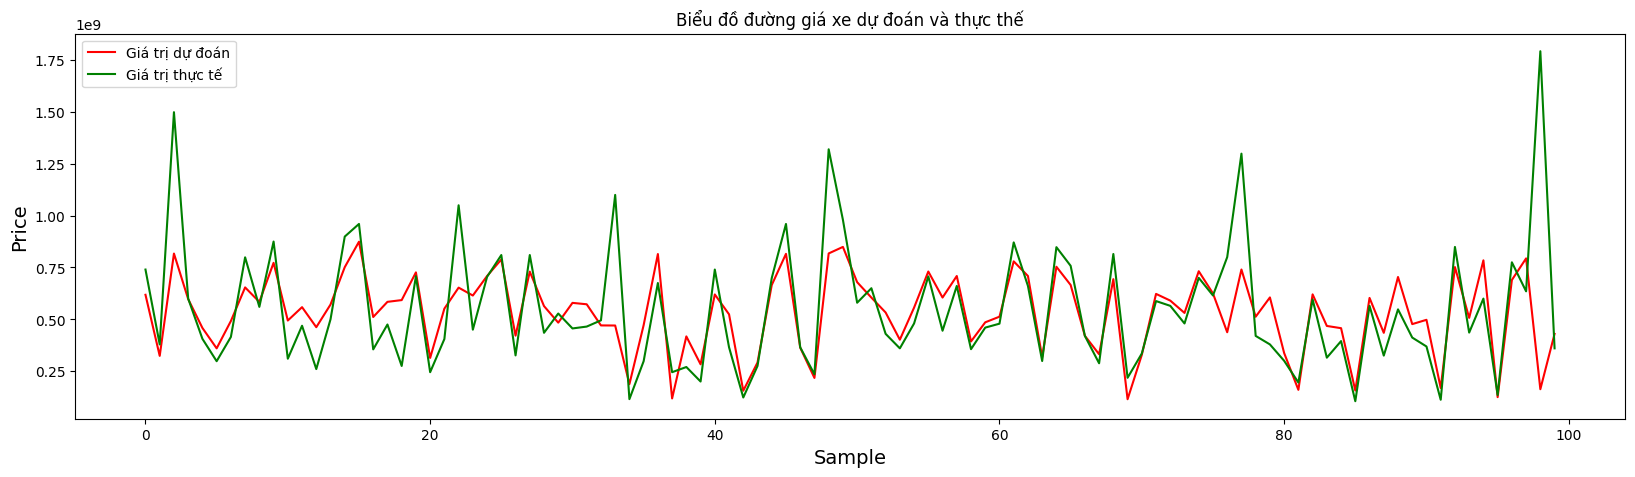

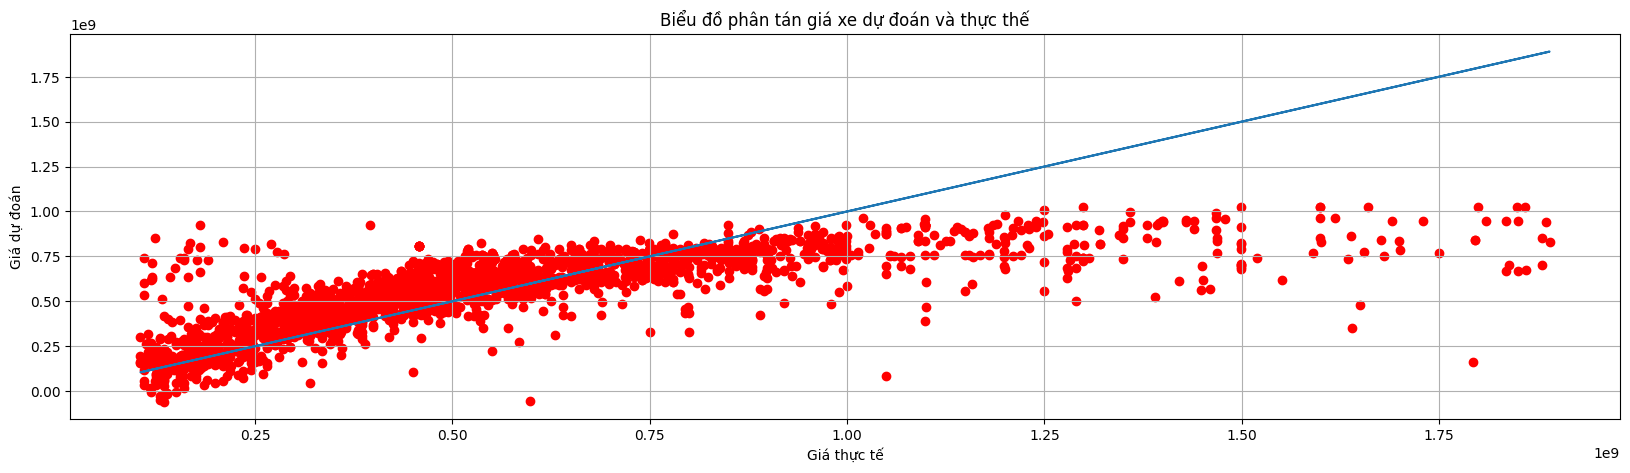

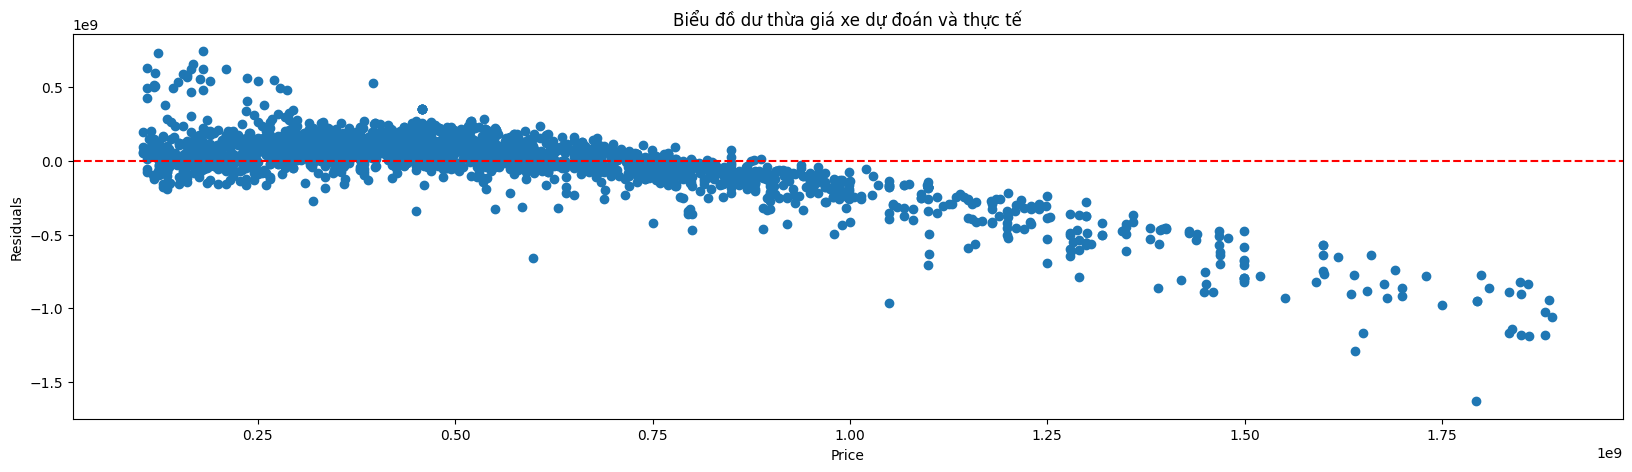

In [ ]:
from sklearn.linear_model import ElasticNet

class ModelElasticNetRegressor:

    def __init__(self, model=None):
        if model is None:
            # You can pass specific hyperparameters for Elastic Net here if needed
            self.model = ElasticNet()
        else:
            self.model = model

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred

    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)
        self.score_r2 = r2_score(y_true, y_pred)

        print(f"MAE: {self.score_mae:.05f}")
        print(f"RMSE: {self.score_rmse:.05f}")
        print(f"MAPE: {self.score_mape:.05f}")
        print(f"R2_SQUARE: {self.score_r2:.05f}")

        return self.score_mae, self.score_rmse, self.score_mape, self.score_r2

    def plot_line(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(0, X_test[0:100].shape[0]), y=self.y_pred[0:100], ax=ax, color='red', label='Giá trị dự đoán')
        sns.lineplot(x=range(0, X_test[0:100].shape[0]), y=y_test[0:100], ax=ax, color='green', label='Giá trị thực tế')

        ax.set_title('Biểu đồ đường giá xe dự đoán và thực thế')
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_scatter(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Giá thực tế')
        plt.ylabel('Giá dự đoán')
        plt.title('Biểu đồ phân tán giá xe dự đoán và thực thế')
        plt.show()

    def plot_residuals(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        residuals = y_pred - y_test

        # Vẽ biểu đồ Residuals
        plt.scatter(y_test, residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Price')
        plt.ylabel('Residuals')
        plt.title('Biểu đồ dư thừa giá xe dự đoán và thực tế')
        plt.show()

# Create an Elastic Net regression model with the best parameters from the grid search
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # Adjust alpha and l1_ratio as needed
elastic_net_reg = ModelElasticNetRegressor(elastic_net_model)
elastic_net_reg.train(X_train, y_train)
elastic_net_y_pred = elastic_net_reg.predict(X_test)
elastic_net_score_mae, elastic_net_score_rmse, elastic_net_score_mape, elastic_net_r2 = elastic_net_reg.evaluate(y_test, elastic_net_y_pred)
elastic_net_reg.plot_line(20, 5, X_test, y_test)
elastic_net_reg.plot_scatter(20, 5, elastic_net_y_pred, y_test)
elastic_net_reg.plot_residuals(20, 5, elastic_net_y_pred, y_test)


### So sánh các mô hình

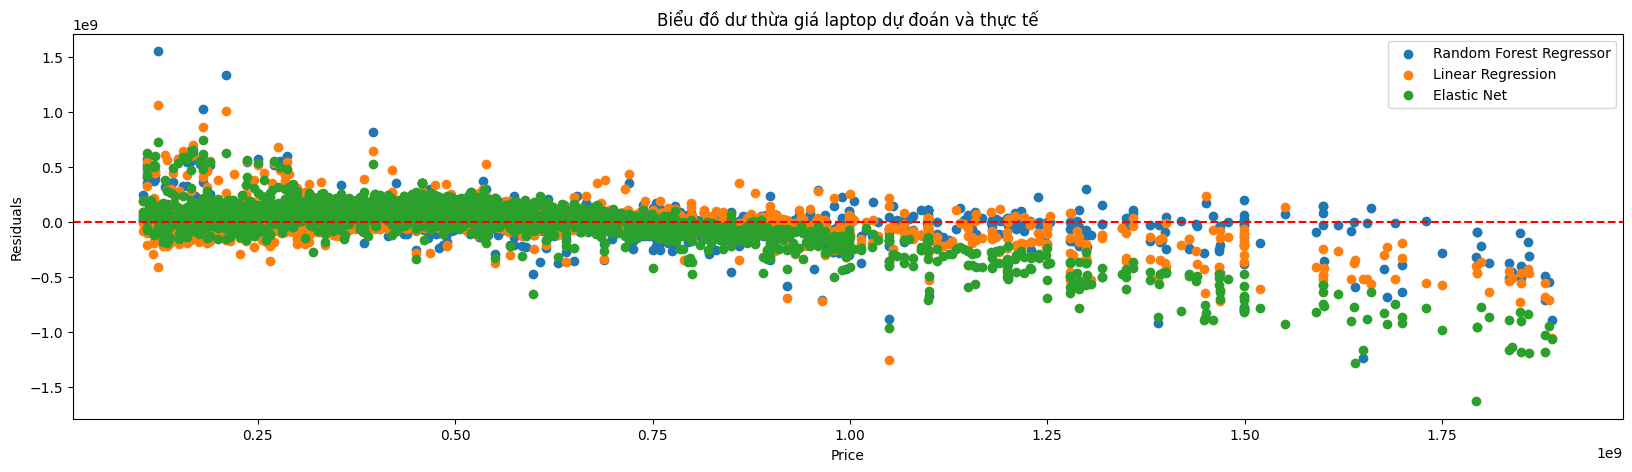

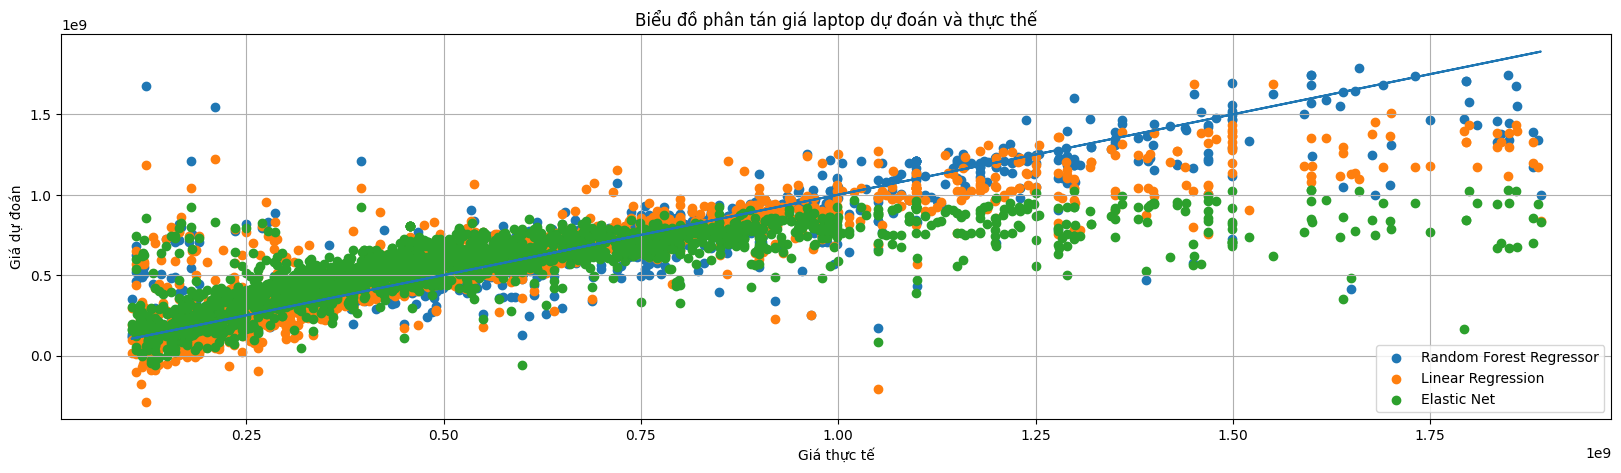

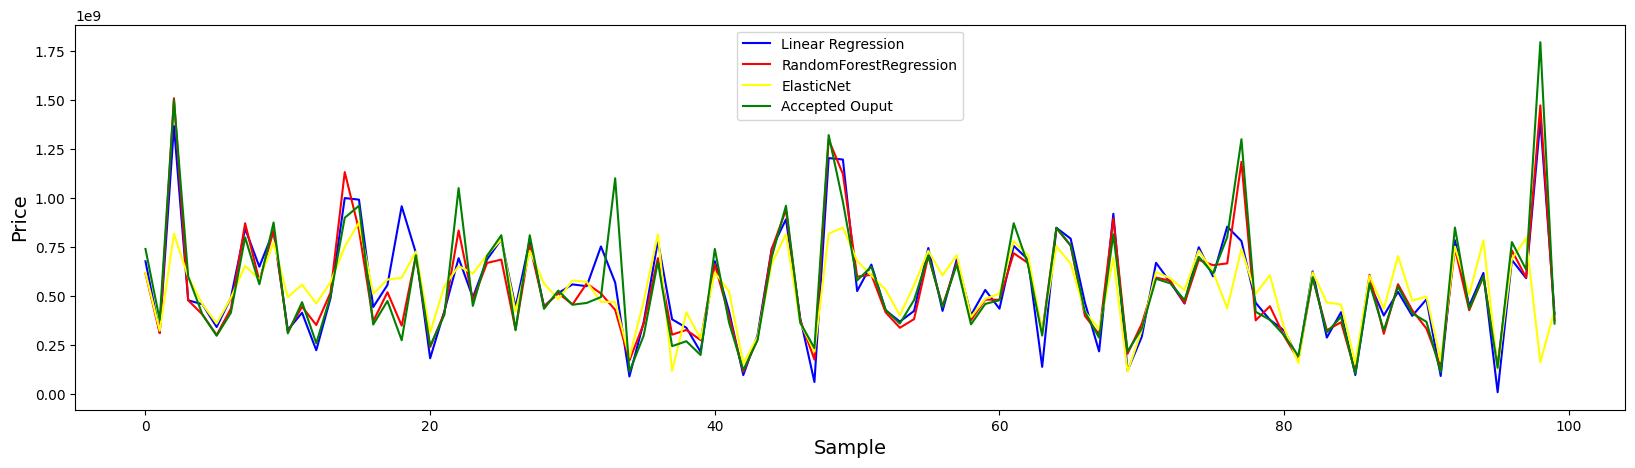

,Model,MAE,RMSE,MAPE,R2_SCORE
0,Random Forest Regressor,57247873.3,124678470.4,0.138,0.852
1,Linear Regression,87444008.0,146974531.9,0.230,0.795
2,Elastic Net,134709838.0,214304993.9,0.289,0.563


In [ ]:
# Vẽ biểu đồ Residuals
height = 5
width = 20
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)

rf_residuals = rf_y_pred - y_test
linear_residuals = linear_y_pred - y_test
el_residuals = elastic_net_y_pred - y_test

plt.scatter(y_test, rf_residuals, label='Random Forest Regressor')
plt.scatter(y_test, linear_residuals, label='Linear Regression')
plt.scatter(y_test, el_residuals, label='Elastic Net')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Price')
plt.ylabel('Residuals')
plt.title('Biểu đồ dư thừa giá laptop dự đoán và thực tế')
plt.legend()
plt.show()

# Vẽ biểu đồ Scatter
height = 5
width = 20
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
plt.scatter(y_test, rf_y_pred, label='Random Forest Regressor')
plt.scatter(y_test, linear_y_pred, label='Linear Regression')
plt.scatter(y_test, elastic_net_y_pred, label='Elastic Net')
plt.plot(y_test, y_test)
plt.grid()
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Biểu đồ phân tán giá laptop dự đoán và thực thế')
plt.legend()
plt.show()


# Vẽ biểu đồ Line
height = 5
width = 20
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)

sns.lineplot(x=range(0, X_test[:100].shape[0]), y=linear_y_pred[:100], ax=ax, color='blue', label='Linear Regression')
sns.lineplot(x=range(0, X_test[:100].shape[0]), y=rf_y_pred[:100], ax=ax, color='red', label='RandomForestRegression')
sns.lineplot(x=range(0, X_test[:100].shape[0]), y=elastic_net_y_pred[:100], ax=ax, color='yellow', label='ElasticNet')
sns.lineplot(x=range(0, X_test[:100].shape[0]), y=y_test[:100], ax=ax, color='green', label='Accepted Ouput')

ax.set_xlabel(xlabel='Sample', fontsize=14)
ax.set_ylabel(ylabel='Price', fontsize=14)
plt.show()

# Tạo dictionary với các giá trị
data = {
    'Model': ['Random Forest Regressor', 'Linear Regression', 'Elastic Net'],
    'MAE': [rf_score_mae, linear_score_mae, elastic_net_score_mae],
    'RMSE': [rf_score_rmse, linear_score_rmse, elastic_net_score_rmse],
    'MAPE': [rf_score_mape, linear_score_mape,elastic_net_score_mape],
    'R2_SCORE' : [rf_r2, linear_r2, elastic_net_r2]
}

# Tạo DataFrame từ dictionary
df = pd.DataFrame(data)

# Làm tròn giá trị và định dạng chuỗi
df['MAE'] = df['MAE'].apply(lambda x: '{:.1f}'.format(round(x, 1)))
df['RMSE'] = df['RMSE'].apply(lambda x: '{:.1f}'.format(round(x, 1)))
df['MAPE'] = df['MAPE'].apply(lambda x: '{:.3f}'.format(round(x, 3)))
df['R2_SCORE'] = df['R2_SCORE'].apply(lambda x: '{:.3f}'.format(round(x, 3)))

df